# Выявление закономерностей, влияющих на успешность игры

**Цель исследования**

На основании исторических данных о продажах игр, оценках пользователей и экспертов, жанрах и платформах необходимо выявить определяющие успешность игр закономерности для определения потенциально популярных продуктов и планирования будущих рекламных кампаний.

Также в рамках исследования необходимо выявить различные закономерности игровой индустрии, взаимосвязи между показателями рынка разработки игр, проверить некоторые гипотезы 

Источник данных: Открытые исторические данные

**Ход исследования:**

1) Выгрузка данных

2) Предобработка данных, в т.ч. замена пропусков, дубликатов, приведение типов и т.д.

3) Исследовательский анализ данных, построение распределений, поиск взаимосвязей на рынке разработки игр

4) Выявление пользовательских предпочтений 

5) Проверка гипотез


## Подготовка и предобработка данных

### Загрузка данных

In [1]:
#импортируем все необходимые библиотеки
import pandas as pd
import random
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy import stats as st
from scipy.stats import ttest_ind
import numpy as np

In [2]:
#зададим общий стиль визуализаций
plt.style.use('bmh')

In [3]:
# загрузим данные
try:
    data_pr = pd.read_csv('/datasets/games.csv')
except:
    data_pr = pd.read_csv('https://????????datasets/games.csv')

In [4]:
#сохраним копию в новый датафрейм
data = data_pr.copy(deep=True)

In [5]:
data.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Данные выгружены корректно, в тоже время в некоторых случаях отсутствуют значения, в основном для категориальных атрибутов. Некоторые атрибуты имеют не "ожидаемый тип", например:
- *Year_of_Release — год выпуска* должно быть целым числом
- *User_Score — оценка пользователей (максимум 10)* должно быть вещественным числом.

### Предобработка данных

Определим кол-в пропусков и посмотрим на уникальные значения в атрибутах. 

Но в первую очередь приведем названия столбцов к нижнему регистру

In [7]:
#приведение названия столбцов к нижнему регистру
for column in data.columns:
    data.rename(columns={column: column.lower()}, inplace=True)

#или
#data.columns = data.columns.str.lower()

In [8]:
#количество пропусков
data.isna().sum().sort_values(ascending=False)

critic_score       8578
rating             6766
user_score         6701
year_of_release     269
name                  2
genre                 2
platform              0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
dtype: int64

In [9]:
#зададим список категориальных атрибутов
cat_list = ['critic_score', 'rating', 'user_score', 'year_of_release', 'name', 'genre', 'platform']
#выведем список уникальных значений
for column in cat_list:
    print(column, data[column].unique())

critic_score [76. nan 82. 80. 89. 58. 87. 91. 61. 97. 95. 77. 88. 83. 94. 93. 85. 86.
 98. 96. 90. 84. 73. 74. 78. 92. 71. 72. 68. 62. 49. 67. 81. 66. 56. 79.
 70. 59. 64. 75. 60. 63. 69. 50. 25. 42. 44. 55. 48. 57. 29. 47. 65. 54.
 20. 53. 37. 38. 33. 52. 30. 32. 43. 45. 51. 40. 46. 39. 34. 35. 41. 36.
 28. 31. 27. 26. 19. 23. 24. 21. 17. 22. 13.]
rating ['E' nan 'M' 'T' 'E10+' 'K-A' 'AO' 'EC' 'RP']
user_score ['8' nan '8.3' '8.5' '6.6' '8.4' '8.6' '7.7' '6.3' '7.4' '8.2' '9' '7.9'
 '8.1' '8.7' '7.1' '3.4' '5.3' '4.8' '3.2' '8.9' '6.4' '7.8' '7.5' '2.6'
 '7.2' '9.2' '7' '7.3' '4.3' '7.6' '5.7' '5' '9.1' '6.5' 'tbd' '8.8' '6.9'
 '9.4' '6.8' '6.1' '6.7' '5.4' '4' '4.9' '4.5' '9.3' '6.2' '4.2' '6' '3.7'
 '4.1' '5.8' '5.6' '5.5' '4.4' '4.6' '5.9' '3.9' '3.1' '2.9' '5.2' '3.3'
 '4.7' '5.1' '3.5' '2.5' '1.9' '3' '2.7' '2.2' '2' '9.5' '2.1' '3.6' '2.8'
 '1.8' '3.8' '0' '1.6' '9.6' '2.4' '1.7' '1.1' '0.3' '1.5' '0.7' '1.2'
 '2.3' '0.5' '1.3' '0.2' '0.6' '1.4' '0.9' '1' '9.7']
year_of_release 

Как видно из приведенных списков:
- в значениях critic_score - есть только целые числа и пустые значения
- в значениях rating - есть только категории и пустые значения
- в значениях user_score - есть вещественные числа, пустые значения и некая категория tbd
- в значениях year_of_release -  есть целые числа и пропуски
- в значениях с наименованием и жанром - есть несколько пустых значений

Каких либо аномальных значений нет.

1) Необходимо изменить тип данных year_of_release на целое число и user_score на вещественное число.
Т.к. в данных есть пропуски, то применим к year_of_release метод astype('Int64')

2) Переводить в целое critic_score не целесобразно, т.к. при расчете среднего и др. статистик по данному атрибуту возникнут вещественные числа

3) Отдельно необходимо преобразовать тип атрибута user_score и провести преобразование значения tbd. Аббревиатура tbd (To Be Determined) означает, что на момент выгрузки данных итоговая оценка пользователей для продукта не опеределена, но будет известна в будущем

Изменение типов произведем после замены/удаления пустых значений и пр. предобработки. Но честно говоря, не вижу особой необходимости замены типов данных. 

Также нас не должны смущать дубликаты игр, т.к. различные игры выходили на различных платформах и в разное время. Так в наборе данных есть 5154 дубликата по названию. При этом полные дубликаты отсутствуют.

In [10]:
display(data[data['name'].duplicated()])
display('Полные дубликаты', data.duplicated().sum())

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
23,Grand Theft Auto V,X360,2013.0,Action,9.66,5.14,0.06,1.41,97.0,8.1,M
35,Call of Duty: Black Ops II,X360,2012.0,Shooter,8.25,4.24,0.07,1.12,83.0,4.8,M
37,Call of Duty: Modern Warfare 3,PS3,2011.0,Shooter,5.54,5.73,0.49,1.57,88.0,3.2,M
41,Call of Duty: Black Ops,PS3,2010.0,Shooter,5.99,4.37,0.48,1.79,88.0,6.4,M
42,Grand Theft Auto V,PS4,2014.0,Action,3.96,6.31,0.38,1.97,97.0,8.3,M
...,...,...,...,...,...,...,...,...,...,...,...
16706,Men in Black II: Alien Escape,GC,2003.0,Shooter,0.01,0.00,0.00,0.00,NaN,tbd,T
16709,SCORE International Baja 1000: The Official Game,PS2,2008.0,Racing,0.00,0.00,0.00,0.00,NaN,NaN,NaN
16710,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16713,Spirits & Spells,GBA,2003.0,Platform,0.01,0.00,0.00,0.00,NaN,NaN,NaN


'Полные дубликаты'

0

In [11]:
#продемонстрируем пример дубликатов по наименованияю
data.query('name == "Grand Theft Auto V"')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
16,Grand Theft Auto V,PS3,2013.0,Action,7.02,9.09,0.98,3.96,97.0,8.2,M
23,Grand Theft Auto V,X360,2013.0,Action,9.66,5.14,0.06,1.41,97.0,8.1,M
42,Grand Theft Auto V,PS4,2014.0,Action,3.96,6.31,0.38,1.97,97.0,8.3,M
165,Grand Theft Auto V,XOne,2014.0,Action,2.81,2.19,0.00,0.47,97.0,7.9,M
1730,Grand Theft Auto V,PC,2015.0,Action,0.39,0.69,0.00,0.09,96.0,7.9,M


**По-этому, в целом, если для какой-либо игры есть пропуски в данных, то можно данные пропуски заменить на соответствующее значение для этой игры, но с другой платформы**

#### Замена пропусков

##### Наименование, жанр

В наименованиях продукта (игр) встречается всего 2 пропуска, поэтому их целесообразнее удалить. Судя по всему это игры на Mega Drive/Genesis 1993 года выпуска. Также для этих двух игр не опеределен жанр, т.о. дополнительное удаление по "пустому" жанру не потребуется

In [12]:
# проверка пустых значений в наименовании игр
data.query('name.isna()')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


In [13]:
# удаление пропусков
data = data.dropna(subset=['name'])

##### Год выпуска

Всего пропущено 269 значений года выпуска для 232 уникальных по наименованию игры. С одной стороны это всего 1,6% набора и можно удалить эти объекты из набора.

С другой стороны, часть наименований игр содержит в себе год, например, Fifa Soccer 2004. Т.е. по идее можно вытянуть год из наименования и заменить пропущенное значение. Но не обязательно год в наимновании == году выпуска. Fifa Soccer 2004 выпущена на PC в 2003 году. Всего таких игр (содержащих число) в наименовании - 66 - и это не обязательно год.

Как видно из примера ниже, информация о годе выпуска Fifa Soccer 2004 есть для других платформ, скорее всего для ряда других игр есть аналогичная информация, поэтому заменим такие пропуски на минимальное значение года выпуска для всех платформ, на которых выходила данная (с пропуском) игра.

In [14]:
# пропуски в годе выпуска
data.query('year_of_release.isna()')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,Madden NFL 2004,PS2,NaN,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E
377,FIFA Soccer 2004,PS2,NaN,Sports,0.59,2.36,0.04,0.51,84.0,6.4,E
456,LEGO Batman: The Videogame,Wii,NaN,Action,1.80,0.97,0.00,0.29,74.0,7.9,E10+
475,wwe Smackdown vs. Raw 2006,PS2,NaN,Fighting,1.57,1.02,0.00,0.41,NaN,NaN,NaN
609,Space Invaders,2600,NaN,Shooter,2.36,0.14,0.00,0.03,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16373,PDC World Championship Darts 2008,PSP,NaN,Sports,0.01,0.00,0.00,0.00,43.0,tbd,E10+
16405,Freaky Flyers,GC,NaN,Racing,0.01,0.00,0.00,0.00,69.0,6.5,T
16448,Inversion,PC,NaN,Shooter,0.01,0.00,0.00,0.00,59.0,6.7,M
16458,Hakuouki: Shinsengumi Kitan,PS3,NaN,Adventure,0.01,0.00,0.00,0.00,NaN,NaN,NaN


In [15]:
# кол-во уникальных наименований игр, для которых отсутствуют годы выпуска
data.query('year_of_release.isna()')['name'].nunique()

232

In [16]:
# игры, в наименованиях которых есть числа
data.query('year_of_release.isna()')[data['name'].str.contains(r'\d+', na=False)]

/tmp/ipykernel_475/2233989615.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data.query('year_of_release.isna()')[data['name'].str.contains(r'\d+', na=False)]


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,Madden NFL 2004,PS2,NaN,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E
377,FIFA Soccer 2004,PS2,NaN,Sports,0.59,2.36,0.04,0.51,84.0,6.4,E
475,wwe Smackdown vs. Raw 2006,PS2,NaN,Fighting,1.57,1.02,0.00,0.41,NaN,NaN,NaN
719,Call of Duty 3,Wii,NaN,Shooter,1.17,0.84,0.00,0.23,69.0,6.7,T
1301,Triple Play 99,PS,NaN,Sports,0.81,0.55,0.00,0.10,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
15953,PDC World Championship Darts 2008,DS,NaN,Sports,0.01,0.00,0.00,0.00,NaN,NaN,NaN
16079,Football Manager 2007,X360,NaN,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN
16293,AKB1/48: Idol to Guam de Koishitara...,X360,NaN,Misc,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16329,Brothers in Arms: Furious 4,X360,NaN,Shooter,0.01,0.00,0.00,0.00,NaN,NaN,M


In [17]:
# пример указанного года выпуска на других плафтормах
data.query('name == "FIFA Soccer 2004"')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
377,FIFA Soccer 2004,PS2,NaN,Sports,0.59,2.36,0.04,0.51,84.0,6.4,E
2606,FIFA Soccer 2004,XB,2003.0,Sports,0.24,0.49,0.00,0.05,82.0,8.2,E
12029,FIFA Soccer 2004,GC,2003.0,Sports,0.05,0.01,0.00,0.00,83.0,6.2,E
13086,FIFA Soccer 2004,GBA,2003.0,Sports,0.04,0.01,0.00,0.00,82.0,7.9,E


In [18]:
# пример указанного года выпуска на других плафтормах
data.query('name == "Call of Duty 3"')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
557,Call of Duty 3,X360,2006.0,Shooter,1.49,0.92,0.02,0.27,82.0,6.5,T
719,Call of Duty 3,Wii,NaN,Shooter,1.17,0.84,0.00,0.23,69.0,6.7,T
1255,Call of Duty 3,PS3,2006.0,Shooter,0.60,0.62,0.03,0.26,80.0,6.9,T
1915,Call of Duty 3,PS2,2006.0,Shooter,0.89,0.03,0.00,0.15,82.0,7.4,T


In [19]:
# проведем замену пропуска в годе выпуска
# для каждого уникального названия игры
for name in data['name'].unique():
# посчитаем минимальное значение года выпуска    
    min_year_release = data.loc[data['name'] == name, 'year_of_release'].min()
# заменим пропущенное значение на минимальное
    data.loc[(data['year_of_release'].isna()) & (data['name'] == name), 'year_of_release'] = min_year_release

In [20]:
# пример замены в для Fifa Soccer 2004
data.query('name == "FIFA Soccer 2004"')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
377,FIFA Soccer 2004,PS2,2003.0,Sports,0.59,2.36,0.04,0.51,84.0,6.4,E
2606,FIFA Soccer 2004,XB,2003.0,Sports,0.24,0.49,0.00,0.05,82.0,8.2,E
12029,FIFA Soccer 2004,GC,2003.0,Sports,0.05,0.01,0.00,0.00,83.0,6.2,E
13086,FIFA Soccer 2004,GBA,2003.0,Sports,0.04,0.01,0.00,0.00,82.0,7.9,E


In [21]:
# пример замены для Call Of Duty 3
data.query('name == "Call of Duty 3"')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
557,Call of Duty 3,X360,2006.0,Shooter,1.49,0.92,0.02,0.27,82.0,6.5,T
719,Call of Duty 3,Wii,2006.0,Shooter,1.17,0.84,0.00,0.23,69.0,6.7,T
1255,Call of Duty 3,PS3,2006.0,Shooter,0.60,0.62,0.03,0.26,80.0,6.9,T
1915,Call of Duty 3,PS2,2006.0,Shooter,0.89,0.03,0.00,0.15,82.0,7.4,T


Как и следовало ожидать (269 пропусков, 232 уникальных наименования) не для всех игр есть данные о годе выпуска на разных платфрмах. Для части игр нет сведений для всех платформах, часть игр выходила только на одной платформе. После первой замены остались пропуски для 146 объектов (133 уникальных наименования). 
Данные объекты можно удалить, а можно заменить пропуски на среднюю дату выхода игр в зависимости от платформы. 

Можно привнести некий элемент случайности в нашу работу и добавить интриги

In [22]:
# пропуски в годе выпуска после замены
data.query('year_of_release.isna()').info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 146 entries, 475 to 16522
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             146 non-null    object 
 1   platform         146 non-null    object 
 2   year_of_release  0 non-null      float64
 3   genre            146 non-null    object 
 4   na_sales         146 non-null    float64
 5   eu_sales         146 non-null    float64
 6   jp_sales         146 non-null    float64
 7   other_sales      146 non-null    float64
 8   critic_score     62 non-null     float64
 9   user_score       80 non-null     object 
 10  rating           81 non-null     object 
dtypes: float64(6), object(5)
memory usage: 13.7+ KB


In [23]:
# кол-во уникальных игр
data.query('year_of_release.isna()')['name'].nunique()

133

Пусть решает случай и подбрасывание монетки. Орел = 1, решка = 2.
Если решка - удаляем из набора данные с пропущенными значениями в годе выпуска.
Если орел - заменяем пропушенные значения года выпуска на среднее по платформе.
Надеюсь,проверяющий не поругает меня за это. Для этого воспользуемся методом random.choice()

Т.к. все значения года выпуска будут заменены, то можно безболезнено производить замену типов на int. 

In [24]:
choice_of_the_year = random.choice([1,2])

In [25]:
# применим аналогичный цикл
if choice_of_the_year == 1:
    for platform in data['platform'].unique():
        avg_year_release = data.loc[data['platform'] == platform, 'year_of_release'].mean()
        data.loc[(data['year_of_release'].isna()) & (data['platform'] == platform), 'year_of_release'] = avg_year_release
    print('Произвели замену на среднее значение для каждой плафтормы')
elif choice_of_the_year == 2:
    data = data.dropna(subset=['year_of_release'])
    print('Удалили объекты с пропущенными значениями года выпуска')

Удалили объекты с пропущенными значениями года выпуска


In [26]:
# изменим тип атрибута year_of_release на int
data['year_of_release'] = data['year_of_release'].astype('int')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16567 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16567 non-null  object 
 1   platform         16567 non-null  object 
 2   year_of_release  16567 non-null  int64  
 3   genre            16567 non-null  object 
 4   na_sales         16567 non-null  float64
 5   eu_sales         16567 non-null  float64
 6   jp_sales         16567 non-null  float64
 7   other_sales      16567 non-null  float64
 8   critic_score     8075 non-null   float64
 9   user_score       9934 non-null   object 
 10  rating           9868 non-null   object 
dtypes: float64(5), int64(1), object(5)
memory usage: 1.5+ MB


##### Оценка критиков (critic score)

Самое большое кол-во пропусков в данных. В первой версии работы была проведена аналогичную замену пропусков на среднее:

1) по наименованию

2) по платформе (для игр, которые выпускались только на одной плафторме) и жанру - остальные оставшиеся пропуски после 

От данной идеи решили отказаться, т.к. замена на среднее может сильно исказить дальнейшие расчеты. Для последующего анализа принято решение не заменять пропущенные значения в оценках критиков (и аналогичные пользовательские значения). 

Также проверили гипотезу, что чем выше продажи игры, тем выше её рейтинг, которая не подтвердилась

<function matplotlib.pyplot.show(close=None, block=None)>

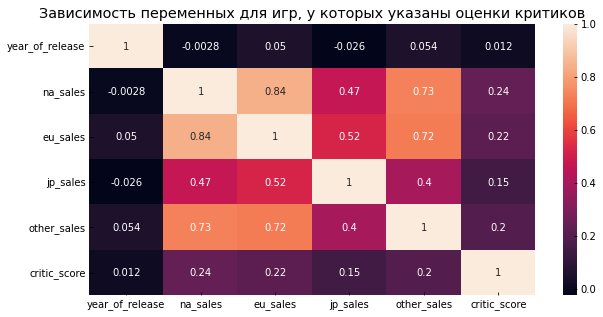

In [27]:
plt.figure(figsize=(10, 5))
plt.title('Зависимость переменных для игр, у которых указаны оценки критиков')
sns.heatmap(data.query('critic_score > 0').corr(), annot=True)
plt.show

Не то, чтобы уж очень прослеживалась взаимосвязь, но зато уже сразу знаем, что продажи в Северной Америке и Европе (а значит и популярность игр или "ожидания от релиза") примерно одинаковые, т.к. рынки похожи, в Японии своя игровая вселенная из-за культурных различий.

Если бы подтверилась сильная взаимосвязь между рейтингом и продажами, то можно было бы подогнать critic_score под объемы продаж, а также провести подобные манипуляции и с user_score.

Пропуски в оценках заменим только для тех игр, у которых есть аналоги на других платформах. Т.е. подберем (посчиатем) среднее значение для игры на других платформах, если для какой-то игры пропущено значение для одной палтформы, заменим данный пропуск на полученное среднее. Такой подход не должен сильно исказить данные. Подобная замена будет произведена для ХХХХ пропусков

In [28]:
#заменим пропущенные значения оценки критиков на среднюю оценку игры на других плафтормах (по наименованию)
for name in data['name'].unique():
    avg_critic_score = data.loc[data['name'] == name, 'critic_score'].mean()
    data.loc[(data['critic_score'].isna()) & (data['name'] == name), 'critic_score'] = avg_critic_score
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16567 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16567 non-null  object 
 1   platform         16567 non-null  object 
 2   year_of_release  16567 non-null  int64  
 3   genre            16567 non-null  object 
 4   na_sales         16567 non-null  float64
 5   eu_sales         16567 non-null  float64
 6   jp_sales         16567 non-null  float64
 7   other_sales      16567 non-null  float64
 8   critic_score     9035 non-null   float64
 9   user_score       9934 non-null   object 
 10  rating           9868 non-null   object 
dtypes: float64(5), int64(1), object(5)
memory usage: 1.5+ MB


In [29]:
# остальные пропуски заменим более сложным циклом, который будет учитывать и платформу и жанр
#for platform in data['platform'].unique():
#    for genre in data['genre'].unique():
#        avg_critic_score = data.loc[(data['platform'] == platform) & (data['genre'] == genre), 'critic_score'].mean()
#        data.loc[(data['critic_score'].isna()) & (data['platform'] == platform) & (data['genre'] == genre), 'critic_score'] = avg_critic_score

#data.info()

In [30]:
#Как видно, есть 381 уникальная пара платформы-жанра, для которых нет релевантных значений для замены. Можно заменить данные пропуски на среднее с учетом плафтормы-жанра и года выпуска. Докрутим наш цикл и выясним, что на самом деле окажется для этих 381 игры набор платформа-жанр-год - уникальны, т.е. заменить по аналогии пропуски для них невозможно. И удалить просто так не хочется, т.к. среди данных игр есть бестселлеры типа super mario, tetris, duck hunt.

#Поэтому заменим на среднюю оценку для жанра

In [31]:
#data.query('critic_score.isna()')

In [32]:
#цикл, заменяющий пропуск на среднее значение для тройки "платформа-жанр-год"
#for platform in data['platform'].unique():
#    for genre in data['genre'].unique():
#        for year in data['year_of_release'].unique():
#            avg_critic_score = data.loc[(data['platform'] == platform) & (data['genre'] == genre) & (data['year_of_release'] == year), 'critic_score'].mean()
#            data.loc[(data['critic_score'].isna()) & (data['platform'] == platform) & (data['genre'] == genre) & (data['year_of_release'] == year), 'critic_score'] = avg_critic_score

#data.info()

In [33]:
#data.query('critic_score.isna()')

In [34]:
#Т.к. при более точной замене не оказалось подходящих троек "платформа-жанр-год", то заменим оставшиеся пропуски в оценке критиков на среднее значение оценки для жанра

In [35]:
#for genre in data['genre'].unique():
#    avg_critic_score = data.loc[(data['genre'] == genre), 'critic_score'].mean()
#    data.loc[(data['critic_score'].isna()) & (data['genre'] == genre), 'critic_score'] = avg_critic_score

##### Пользовательская оценка (user_score)

Предположительно в момент выгрузки для части игр не была проставлена пользовательска оценка, всего таких игр:

In [36]:
print(data.query('user_score == "tbd"')['user_score'].count())

2394


из начального набора. Чем могут быть вызваны такие значения пользователских оценок?

Год выпуска? Нет. Неопределенные оценки растут с 2000 по 2009, а затем падают. На дворе 2017 год, но за 5 лет оценки так и не определили. Странно. В целом кол-во игр tbd и общее количество игр в наборе данных по годам растет примерно пропорционально

In [37]:
data.query('user_score == "tbd"').groupby('year_of_release')['name'].count()

year_of_release
1997      2
1999      8
2000     43
2001     84
2002    193
2003     96
2004    107
2005    122
2006    127
2007    193
2008    330
2009    405
2010    332
2011    218
2012     26
2013     15
2014     21
2015     38
2016     34
Name: name, dtype: int64

In [38]:
data.groupby('year_of_release')['name'].count()

year_of_release
1980       9
1981      46
1982      36
1983      17
1984      14
1985      14
1986      21
1987      16
1988      15
1989      17
1990      16
1991      42
1992      43
1993      60
1994     122
1995     219
1996     263
1997     290
1998     379
1999     339
2000     351
2001     486
2002     845
2003     783
2004     764
2005     948
2006    1018
2007    1202
2008    1441
2009    1430
2010    1269
2011    1153
2012     662
2013     548
2014     581
2015     606
2016     502
Name: name, dtype: int64

Жанром? Самые "неопределенные жанры" - Misc, Sport, Action

In [39]:
data.query('user_score == "tbd"').groupby('genre')['name'].count().sort_values()

genre
Role-Playing     30
Fighting         38
Strategy         39
Shooter          96
Platform        135
Adventure       156
Puzzle          210
Racing          230
Simulation      233
Action          374
Sports          410
Misc            443
Name: name, dtype: int64

Платформой? "Проблемы" у компании Нинтендо и её платформ Wii & DS

In [40]:
data.query('user_score == "tbd"').groupby('platform')['name'].count().sort_values()

platform
WiiU      5
PS4       6
PSV       7
XOne     11
PS       44
PC       49
3DS      54
X360     83
PS3      87
GC      102
PSP     123
XB      149
PS2     237
GBA     259
Wii     431
DS      747
Name: name, dtype: int64

Так что же делать? Почти половина игр не имеет пользовательских оценок и из них четверть "неопределенные" оценки.

**Первоначальные рассуждения**

Сначала обработаем пропуски. Заменим пустые значения на релевантные значения по наименованиям игр. Но ничего не выйдет, т.к тип атрибута c пользовательскими оценками - object. Заметим, что ни у одной игры не стоит оценка 10. Предварительно выполним замену строки tbd на 10 и преобразуем в вещественное число. Далее проведем манипуляции по замене оценки 10 и пустых значений на среднее по названию, платформе-году, платфоррме-году-жанру

**Итоговое решение**

Проведем полную замену tbd на NaN, заменим тип и проставим пользователскую оценку для тех игр, для которых есть аналоги на других платформах

In [41]:
data['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

In [42]:
#замена tbd  в пользовательских оценках и замена типа
data['user_score'] = data['user_score'].replace('tbd', np.NaN)
data['user_score'] = data['user_score'].astype('float')

In [43]:
#data['user_score'] = data['user_score'].astype('str').str.replace('tbd', '10').astype('str')
#data['user_score'] = data['user_score'].astype('float64', errors='ignore' )
#data['user_score'].unique()

In [44]:
# замена пустых пользовательских оценок и оценок "10" на среднее по имени
for name in data['name'].unique():
    avg_user_score = data.loc[data['name'] == name, 'user_score'].mean()
    data.loc[(data['user_score'].isna()) & (data['name'] == name), 'user_score'] = avg_user_score

In [45]:
# замена пустых пользовательских оценок и оценок "10" на среднее по тройке "платформа-жанр-год"
#for platform in data['platform'].unique():
#    for genre in data['genre'].unique():
#        for year in data['year_of_release'].unique():
#            avg_user_score = data.loc[(data['platform'] == platform) & (data['genre'] == genre) & (data['year_of_release'] == year), 'user_score'].mean()
#            data.loc[(data['user_score'].isna() | (data['user_score'] == 10)) & (data['platform'] == platform) & (data['genre'] == genre) & (data['year_of_release'] == year), 'user_score'] = avg_user_score

In [46]:
# замена пустых пользовательских оценок и оценок "10" на среднее по паре "платформа-жанр"
#for platform in data['platform'].unique():
#    for genre in data['genre'].unique():
#        avg_user_score = data.loc[(data['platform'] == platform) & (data['genre'] == genre), 'user_score'].mean()
#        data.loc[(data['user_score'].isna() | (data['user_score'] == 10)) & (data['platform'] == platform) & (data['genre'] == genre), 'user_score'] = avg_user_score

In [47]:
# замена пустых пользовательских оценок и оценок "10" на среднее по жанру
#for genre in data['genre'].unique():
#    avg_user_score = data.loc[(data['genre'] == genre), 'user_score'].mean()
#    data.loc[(data['user_score'].isna() | (data['user_score'] == 10)) & (data['genre'] == genre), 'user_score'] = avg_user_score

In [48]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16567 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16567 non-null  object 
 1   platform         16567 non-null  object 
 2   year_of_release  16567 non-null  int64  
 3   genre            16567 non-null  object 
 4   na_sales         16567 non-null  float64
 5   eu_sales         16567 non-null  float64
 6   jp_sales         16567 non-null  float64
 7   other_sales      16567 non-null  float64
 8   critic_score     9035 non-null   float64
 9   user_score       8639 non-null   float64
 10  rating           9868 non-null   object 
dtypes: float64(6), int64(1), object(4)
memory usage: 1.5+ MB


##### Рейтинг ESRB

Пропуски в данной категориальном атрибуте не заменить, поэтому оставим как есть. Теоеретически данное значение можно предсказать на основании названии игры, её жанра

In [49]:
data.groupby(['genre','rating'])['name'].count().reset_index()

,genre,rating,name
0,Action,AO,1
1,Action,E,414
2,Action,E10+,481
3,Action,EC,1
4,Action,M,604
5,Action,T,675
6,Adventure,E,159
7,Adventure,E10+,67
8,Adventure,EC,2
9,Adventure,M,98


In [50]:
data.groupby('rating')['name'].count().reset_index().sort_values(by='name', ascending=False)

,rating,name
1,E,3958
7,T,2930
5,M,1554
2,E10+,1412
3,EC,8
4,K-A,3
6,RP,2
0,AO,1


Как видно из данного распределения, в основном основными классами во всех жанрах игр являются рейтингом Е (все), Е10+ (все от 10 лет), Т (тинейджеры от 13 до 17), M (старше 17)

### Добавление нового столбца

Добавим новый столбец с суммой всех продаж игр

In [51]:
data['sales'] = data['na_sales'] + data['eu_sales'] + data['jp_sales'] + data['other_sales']

In [52]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16567 entries, 0 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16567 non-null  object 
 1   platform         16567 non-null  object 
 2   year_of_release  16567 non-null  int64  
 3   genre            16567 non-null  object 
 4   na_sales         16567 non-null  float64
 5   eu_sales         16567 non-null  float64
 6   jp_sales         16567 non-null  float64
 7   other_sales      16567 non-null  float64
 8   critic_score     9035 non-null   float64
 9   user_score       8639 non-null   float64
 10  rating           9868 non-null   object 
 11  sales            16567 non-null  float64
dtypes: float64(7), int64(1), object(4)
memory usage: 1.6+ MB


### Неявные дубликаты

Рассмотрим неявные дубликаты по наименованию игры и платформы

In [53]:
data[data.duplicated(subset=['name', 'platform'])]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sales
1591,Need for Speed: Most Wanted,X360,2005,Racing,1.0,0.13,0.02,0.10,83.0,8.5,T,1.25
4127,Sonic the Hedgehog,PS3,1991,Platform,0.0,0.48,0.00,0.00,43.0,4.1,E10+,0.48
11715,Need for Speed: Most Wanted,PC,2012,Racing,0.0,0.06,0.00,0.02,82.0,8.5,T,0.08
16230,Madden NFL 13,PS3,2012,Sports,0.0,0.01,0.00,0.00,83.0,5.5,E,0.01


Посмотрим в целом на игру Need for Speed: Most Wanted

In [54]:
data.query('name == "Need for Speed: Most Wanted"')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sales
253,Need for Speed: Most Wanted,PS2,2005,Racing,2.03,1.79,0.08,0.47,82.0,9.100000,T,4.37
523,Need for Speed: Most Wanted,PS3,2012,Racing,0.71,1.46,0.06,0.58,77.5,8.377778,NaN,2.81
1190,Need for Speed: Most Wanted,X360,2012,Racing,0.62,0.78,0.01,0.15,83.0,8.500000,T,1.56
1591,Need for Speed: Most Wanted,X360,2005,Racing,1.00,0.13,0.02,0.10,83.0,8.500000,T,1.25
1998,Need for Speed: Most Wanted,XB,2005,Racing,0.53,0.46,0.00,0.05,83.0,8.800000,T,1.04
2048,Need for Speed: Most Wanted,PSV,2012,Racing,0.33,0.45,0.01,0.22,77.5,8.377778,NaN,1.01
3581,Need for Speed: Most Wanted,GC,2005,Racing,0.43,0.11,0.00,0.02,80.0,9.100000,T,0.56
5972,Need for Speed: Most Wanted,PC,2005,Racing,0.02,0.23,0.00,0.04,82.0,8.500000,T,0.29
6273,Need for Speed: Most Wanted,WiiU,2013,Racing,0.13,0.12,0.00,0.02,77.5,8.377778,NaN,0.27
6410,Need for Speed: Most Wanted,DS,2005,Racing,0.24,0.01,0.00,0.02,45.0,6.100000,E,0.27


In [55]:
data.query('name == "Madden NFL 13"')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sales
507,Madden NFL 13,X360,2012,Sports,2.53,0.15,0.0,0.17,81.0,5.8,E,2.85
604,Madden NFL 13,PS3,2012,Sports,2.11,0.22,0.0,0.23,83.0,5.5,E,2.56
3986,Madden NFL 13,Wii,2012,Sports,0.47,0.00,0.0,0.03,77.0,7.3,E,0.50
5887,Madden NFL 13,PSV,2012,Sports,0.28,0.00,0.0,0.02,63.0,7.3,E,0.30
7066,Madden NFL 13,WiiU,2012,Sports,0.21,0.00,0.0,0.02,75.0,6.7,E,0.23
16230,Madden NFL 13,PS3,2012,Sports,0.00,0.01,0.0,0.00,83.0,5.5,E,0.01


Подозрительным может выглядеть однинаковые записи для платформы X360 или РС (need for speed) или для PS3 (madden NFL13). Но нельзя исключать, что это может быть или ремастер игры, дополнительный "юбилейный выпуск", новый официальный мод, в целом перевыпуск или вообще цифровая и физическая копии игры.

Предлагаю оставить эти "неявные" дубликаты, т.к. причину их происхождения мы не знаем

## EDA 

### Годы выпуска, общие продажи по годам, платформам, жанрам

In [56]:
data.describe()

,year_of_release,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,sales
count,16567.000000,16567.000000,16567.000000,16567.000000,16567.000000,9035.000000,8639.000000,16567.000000
mean,2006.488562,0.263975,0.145814,0.078020,0.047567,68.783089,7.088010,0.535376
std,5.864900,0.816474,0.505364,0.310068,0.187476,14.093330,1.501612,1.554281
min,1980.000000,0.000000,0.000000,0.000000,0.000000,13.000000,0.000000,0.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,60.000000,6.300000,0.060000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,71.000000,7.400000,0.170000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,79.000000,8.200000,0.470000
max,2016.000000,41.360000,28.960000,10.220000,10.570000,98.000000,9.700000,82.540000


#### Годы выпуска

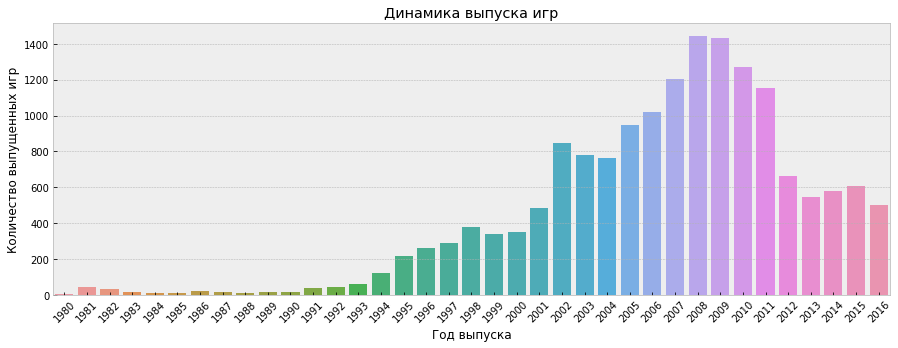

In [57]:
plt.figure(figsize=(15,5))
plt.title('Динамика выпуска игр')
sns.countplot(data=data, x='year_of_release')
plt.xticks(rotation=45)
plt.xlabel('Год выпуска')
plt.ylabel('Количество выпущенных игр')
plt.show()

Бум геймдева, судя по нашим данным, пришелся на 2002 год. Примерно с конца 90-х началось массовое распространение интернета, появление технологий Java и Adobe Flash, была выпущена консоль PS2. В целом начало 2000 характеризуется большими инновациями в разработке игр, появлением новых модификаций от пользователей. В Китае в начале 2000-х запретили продажу консолей, что привелок росту популярности компьютерных игр, особенно в жанре ММО. 

С 2009 года количество выпускаемых игр уменьшается.

#### Объемы продаж

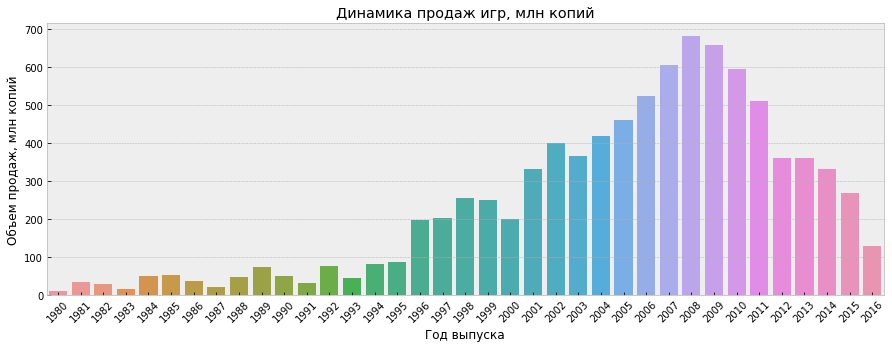

In [58]:
plt.figure(figsize=(15,5))
plt.title('Динамика продаж игр, млн копий')
sns.barplot(data=data.groupby('year_of_release')['sales'].sum().reset_index(), x='year_of_release', y='sales')
plt.xticks(rotation=45)
plt.xlabel('Год выпуска')
plt.ylabel('Объем продаж, млн копий')
plt.show()

Аналогичная картина наблюдается с общим объемом продаж. Возможно в нашем наборе учитываются только игры на физических носителях и не учтены продажи цифровых копий.

Каких либо реальных подтверждений такой динамики нет. 

Пиратство?

#### Платформы

Наиболее популярными платформами являются PS2-3, Xbox360, Wii, DS

In [59]:
data.groupby('platform')['sales'].sum().reset_index().sort_values(by='sales', ascending=False)

,platform,sales
16,PS2,1247.16
28,X360,966.61
17,PS3,935.19
26,Wii,903.31
4,DS,804.28
15,PS,727.58
18,PS4,314.14
6,GBA,313.73
19,PSP,293.57
13,PC,258.86


Построим динамику продаж для топ-15 плафторм из списка

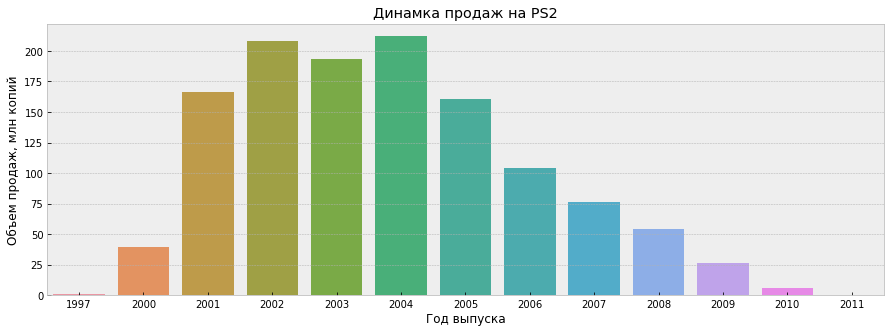

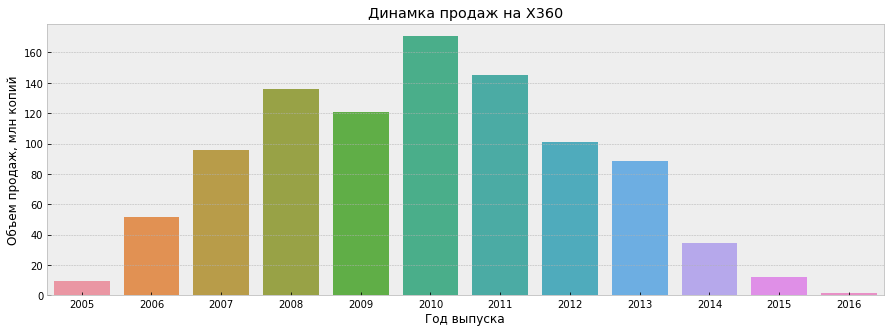

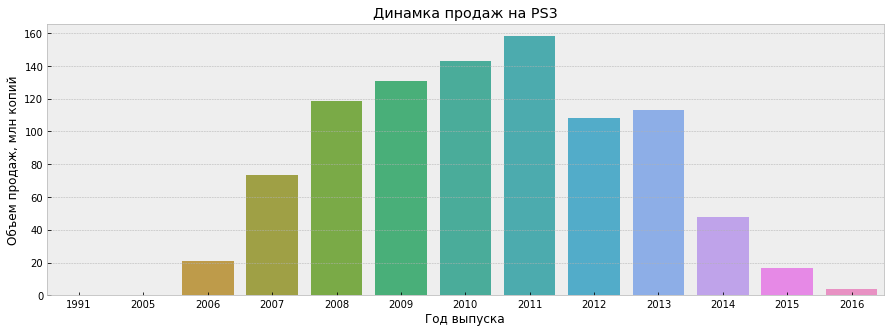

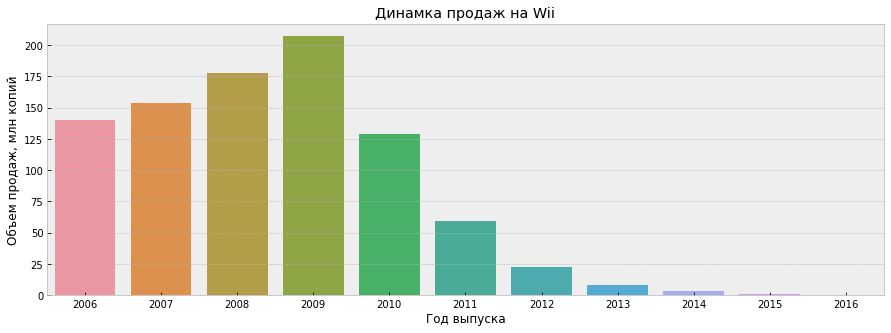

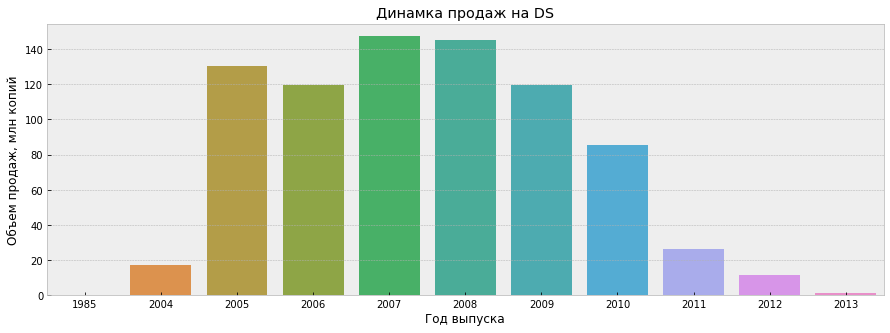

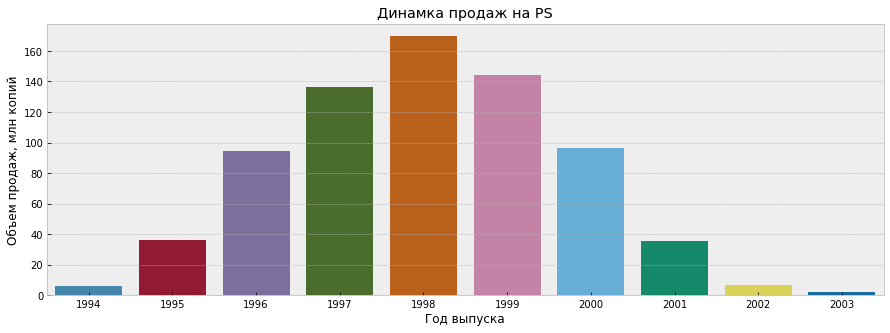

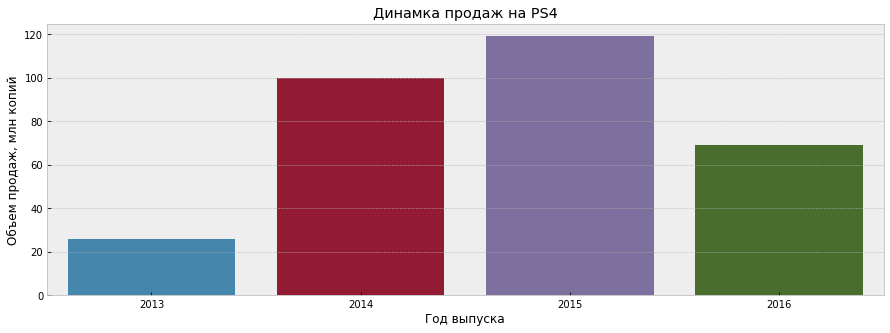

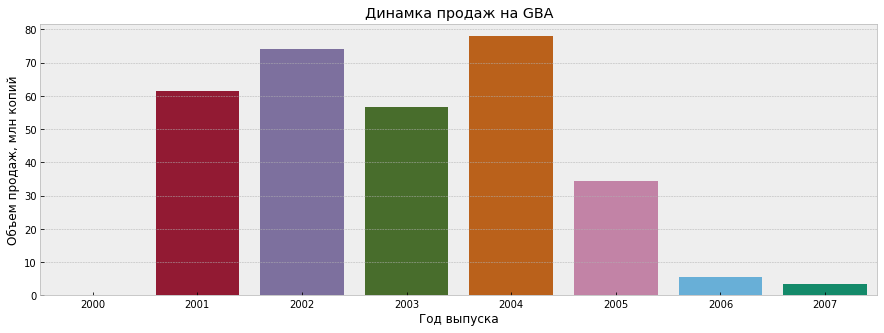

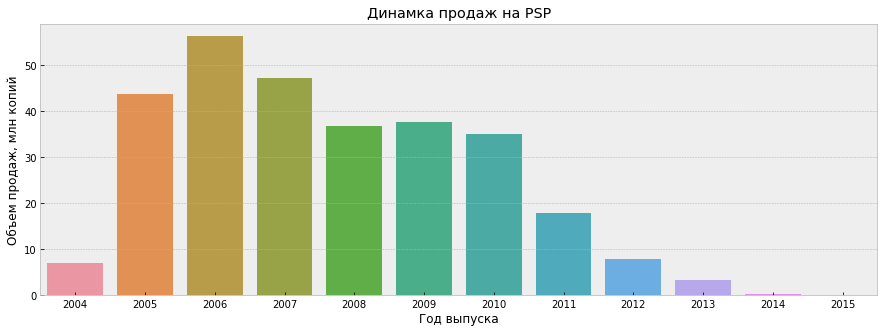

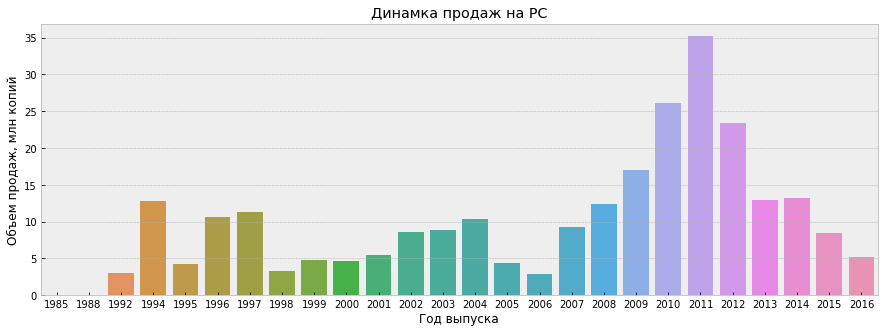

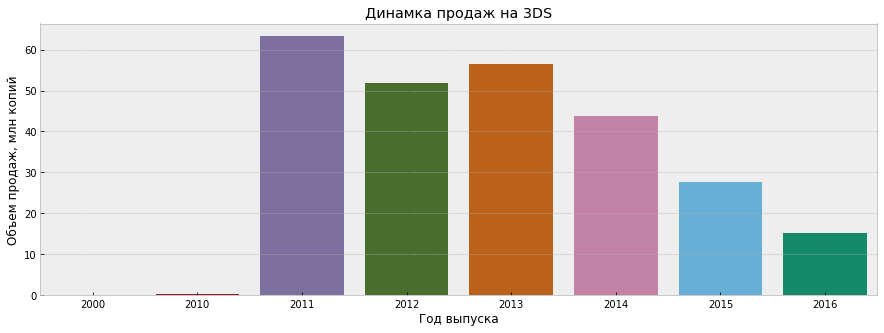

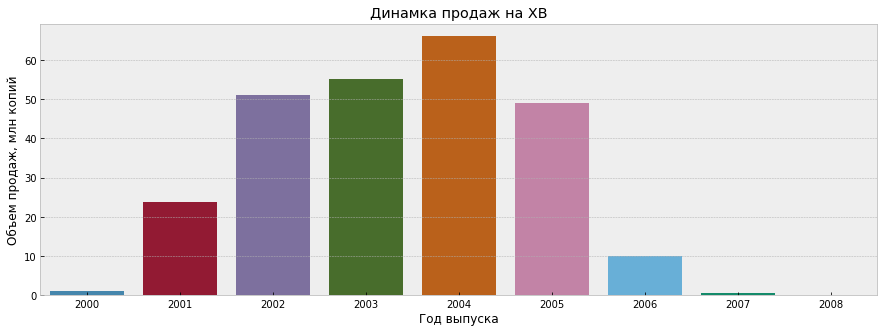

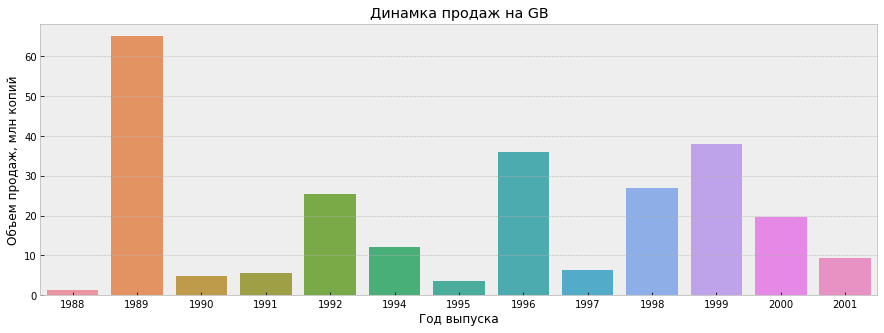

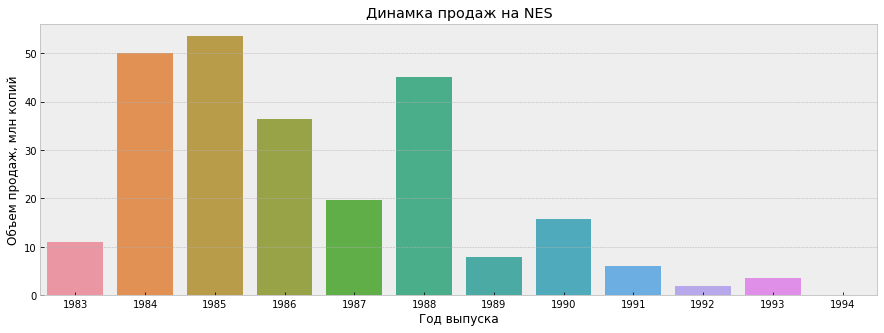

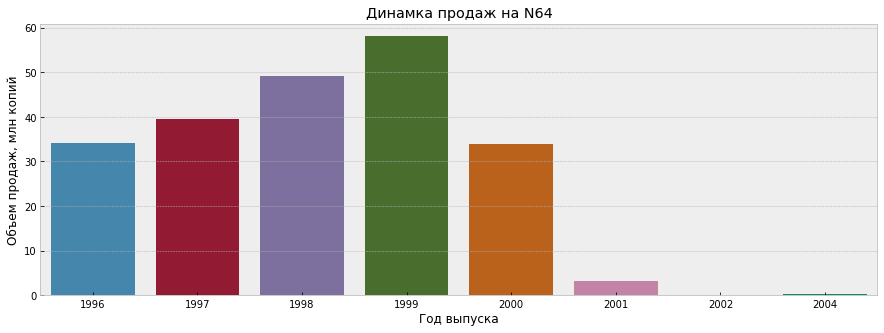

In [60]:
top_platform = data.groupby('platform')['sales'].sum().reset_index().sort_values(by='sales', ascending=False).head(15)['platform'].unique()
data_platform = data.groupby(['year_of_release', 'platform'])['sales'].sum().reset_index()
for tp in top_platform:
    plt.figure(figsize=(15,5))
    plt.title(f'Динамка продаж на {tp}')
    sns.barplot(data=data_platform.query('platform == @tp'), x='year_of_release', y='sales')
    plt.xlabel('Год выпуска')
    plt.ylabel('Объем продаж, млн копий')
    plt.show()

В целом картина динамики объема продаж (в реальном выражении) вполне логична:
- бурный рост в течении 2-3 лет или резкий скачок продаж, 
- хайп (стабильное плато)
- постепенное затухание

и такая картина характерна для консолей. В целом для консолей также характерно то, что основная масса пользователей (не фанаты) покупают консоли через 1-2 года, т.к. за это время после появления новой консоли происходит её доработка и модернизация, "допилка" игр.

Немного другая динамика для PC, для которых динамика продаж соответствует общему тренду динамики продаж. Резкий рост в 2009-2011, далее спад. до 2007 года - колебания в окрестности 5 млн копий в год.

По графикам видно, что среднее время жизни консоли составляет 7-10 лет. В теории консоли нового поколения появляются раз в 5 лет

Рассмотрим отдельно период 2000-2016 год, т.е. с начала массового появления игровых консолей.

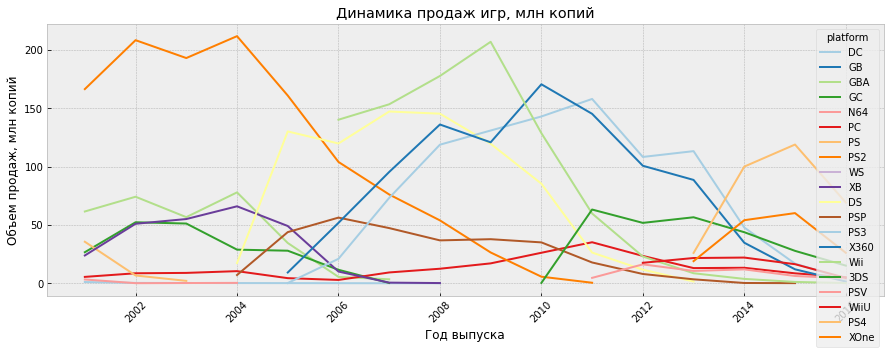

In [61]:
plt.figure(figsize=(15,5))
plt.title('Динамика продаж игр, млн копий')
sns.lineplot(data=data.query('year_of_release > 2000').groupby(['year_of_release','platform']).sum().reset_index(), 
             x='year_of_release', y='sales', hue='platform', palette='Paired')
plt.xticks(rotation=45)
plt.xlabel('Год выпуска')
plt.ylabel('Объем продаж, млн копий')
plt.show()

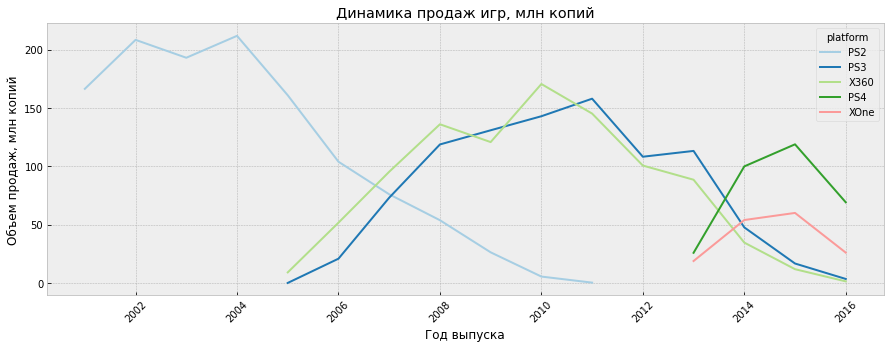

In [62]:
# выделим динамику отдельных топ-платформ
plt.figure(figsize=(15,5))
plt.title('Динамика продаж игр, млн копий')
sns.lineplot(data=data.query('year_of_release > 2000 & (platform == "PS2" | platform == "PS3" | platform =="PS4" | platform =="XOne" | platform =="X360")').groupby(['year_of_release','platform']).sum().reset_index(), 
             x='year_of_release', y='sales', hue='platform', palette='Paired')
plt.xticks(rotation=45)
plt.xlabel('Год выпуска')
plt.ylabel('Объем продаж, млн копий')
plt.show()

На примере консолей Play Station прослеживается:
- приемственность поколений консолей (продажи игр на новые консоли, а следовательно продажи и появление самих новых консолей, начинаются на нисходящем тренде консолей предыдущего поколения) 
- и борьба конкурентов за рынок (одновременный выход на рынок PS3 и X360, PS4 и XOne)

### Выбор актуального периода

Т.к. нам требуется построить прогноз на 2017 год, с начала 2009 года наблюдается спад продаж, то целесообразно при дальнейшем анализе основываться на данных за период 2009-2016 гг. Как раз полностью нивелируется влияние старых платформ, продажи игр для одних из самых популярных консолей в мире РS3 и Х360 будут на минимуме. Также (судя по данным за 2016 год) продажи игр для популярных консолей следующего поколения PS4 и XOne также находятся на нисходящем тренде. 

В таком случае для рассмариваемого периода самыми популярными платформами являются PS3, X360, Wii, PS4, 3DS, DS, XOne.

А в более краткосрочной ретроспективе (2013-2016 гг.) - PS4, PS3, XOne, 3DS, X360

In [63]:
# объем продаж в разрезе плафторм с 2009 года
data.query('year_of_release >= 2009').groupby('platform')['sales'].sum().reset_index().sort_values(by='sales', ascending=False)

,platform,sales
4,PS3,721.58
10,X360,674.12
8,Wii,432.03
5,PS4,314.14
0,3DS,258.51
1,DS,244.45
11,XOne,159.32
2,PC,141.87
6,PSP,102.33
9,WiiU,82.19


In [64]:
# объем продаж в разрезе плафторм с 2013 года
data.query('year_of_release >= 2013').groupby('platform')['sales'].sum().reset_index().sort_values(by='sales', ascending=False)

,platform,sales
4,PS4,314.14
3,PS3,181.43
10,XOne,159.32
0,3DS,143.25
9,X360,136.80
8,WiiU,64.63
2,PC,40.06
6,PSV,32.99
7,Wii,13.66
5,PSP,3.74


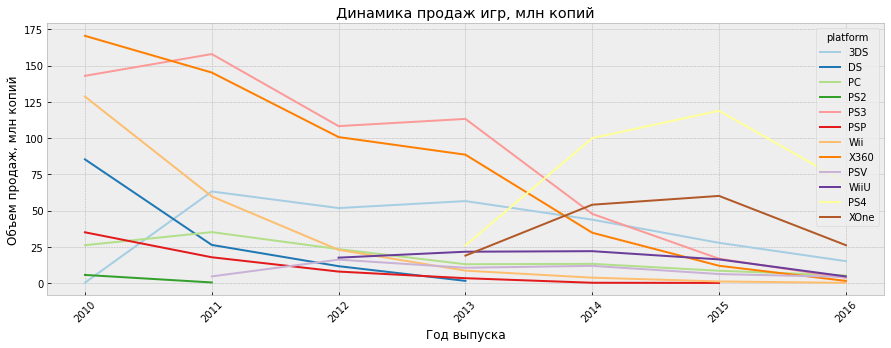

In [65]:
# динамика продаж в разрезе плафторм с 2009 года
plt.figure(figsize=(15,5))
plt.title('Динамика продаж игр, млн копий')
sns.lineplot(data=data.query('year_of_release > 2009').groupby(['year_of_release','platform']).sum().reset_index(), 
             x='year_of_release', y='sales', hue='platform', palette='Paired')
plt.xticks(rotation=45)
plt.xlabel('Год выпуска')
plt.ylabel('Объем продаж, млн копий')
plt.show()

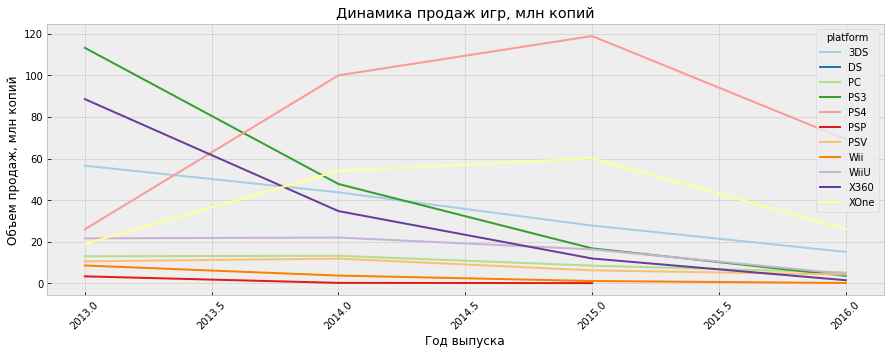

In [66]:
# динамика продаж в разрезе плафторм с 2013 года
plt.figure(figsize=(15,5))
plt.title('Динамика продаж игр, млн копий')
sns.lineplot(data=data.query('year_of_release >= 2013').groupby(['year_of_release','platform']).sum().reset_index(), 
             x='year_of_release', y='sales', hue='platform', palette='Paired')
plt.xticks(rotation=45)
plt.xlabel('Год выпуска')
plt.ylabel('Объем продаж, млн копий')
plt.show()

#### Перспективные платформы

Рассмотрим период с 2009 года. Наиобльшие медианные продажи наблюдаются у PS3, X360, PS4, 3DS, XOne (в порядке убывания)

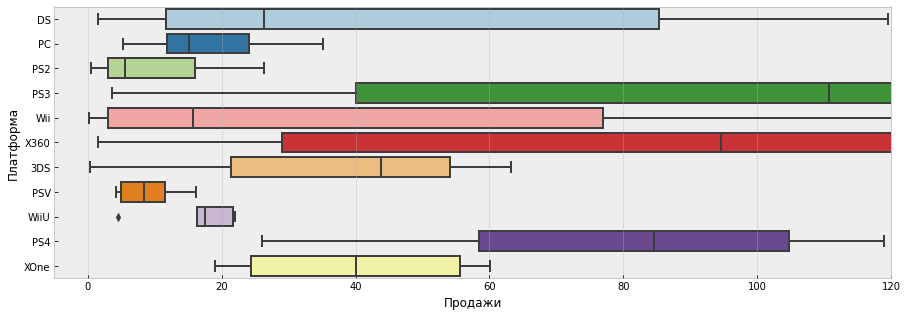

In [67]:
plt.figure(figsize=(15,5))
sns.boxplot(data = data.query('year_of_release >= 2009 & platform !="PSP"').groupby(['year_of_release', 'platform'])['sales'].sum().reset_index(), 
            x='sales', y='platform', palette='Paired')
plt.xlabel('Продажи')
plt.ylabel('Платформа')
plt.xlim(-5,120)
plt.show()

А также для периода 2013-2016 гг. Аналогично, наибольшие медианные продажи наблюдаются у PS4, X0ne, 3DS, PS3, X360

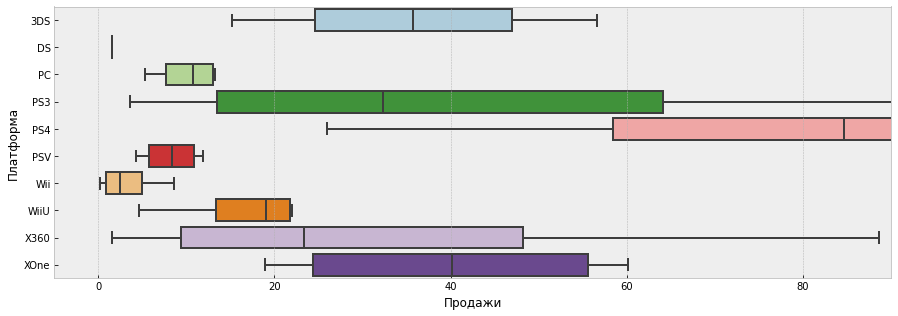

In [68]:
plt.figure(figsize=(15,5))
sns.boxplot(data = data.query('year_of_release >= 2013 & platform !="PSP"').groupby(['year_of_release', 'platform'])['sales'].sum().reset_index(), 
            x='sales', y='platform', palette='Paired')
plt.xlabel('Продажи')
plt.ylabel('Платформа')
plt.xlim(-5,90)
plt.show()

Как и предполагалось, самыми "перспективными" платформами являются PS4, PS3, XOne, 3DS, X360.

**Видимо, для дальнейшего анализа целесообразно рассмотреть все-таки период 2013-2016 гг.**

In [69]:
#data.query('year_of_release >= 2013').pivot_table(index=['year_of_release', 'platform'],
#                                                  values=['na_sales', 'eu_sales', 'jp_sales', 'other_sales','sales'],
#                                                  aggfunc='sum').reset_index()

### Отзывы vs. продажи

Частично на корреляции объемов продаж мы смотрели в первом блоке нашего исследования. 
В целом для всего массива (для всех годов) выявляются сильные корреляции между продажами в Америке и Европе, а также между общими продажами и продажами в Америке и Европе.

Оценки пользователей и продажи не связаны между собой.

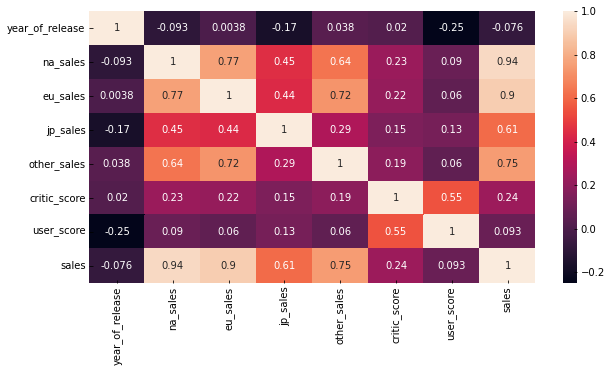

In [70]:
# корреляции для всего набора
plt.figure(figsize=(10,5))
sns.heatmap(data.corr(), annot=True)
plt.show()

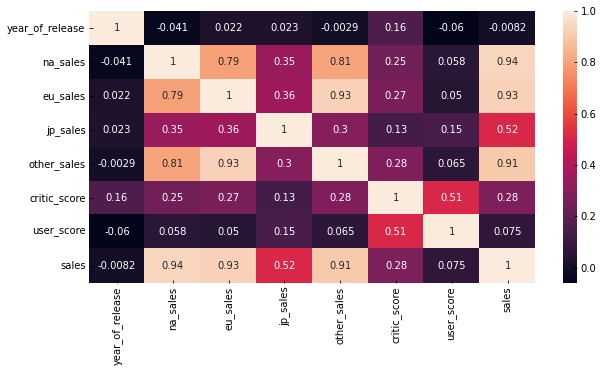

In [71]:
# корреляции поcле 2009 года
plt.figure(figsize=(10,5))
sns.heatmap(data.query('year_of_release >= 2009').corr(), annot=True)
plt.show()

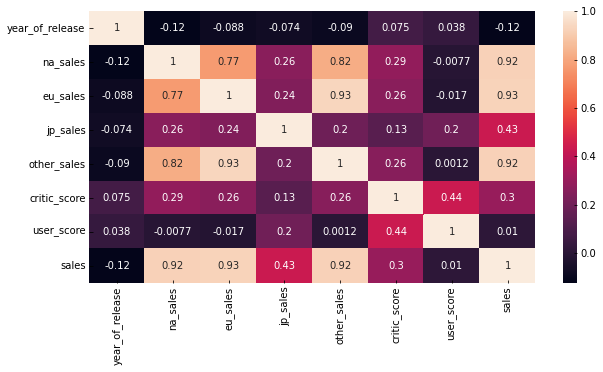

In [72]:
# корреляции после 2013 года
plt.figure(figsize=(10,5))
sns.heatmap(data.query('year_of_release >= 2013').corr(), annot=True)
plt.show()

С натяжкой, корреляцию между продажами в Америке, Европе, общими продажами и оценкой критиков можно назвать слабой (около 0,3). Возможно, в оценке критиков учитывается объем продаж.

Рассмотрим корреляцию оценок и продаж в разрезе платформ PS4, PS3, XOne, 3DS, X360 после 2013 года

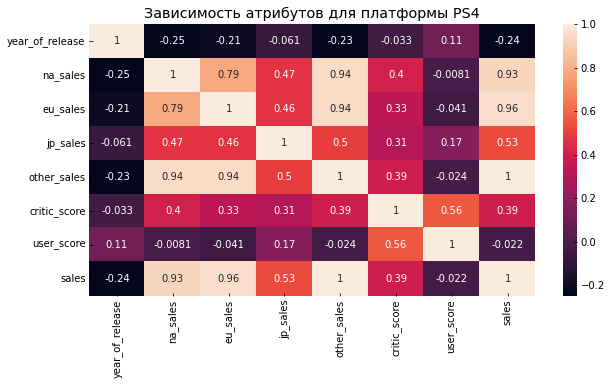

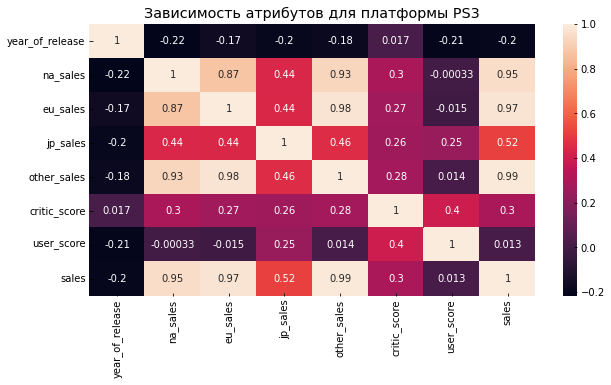

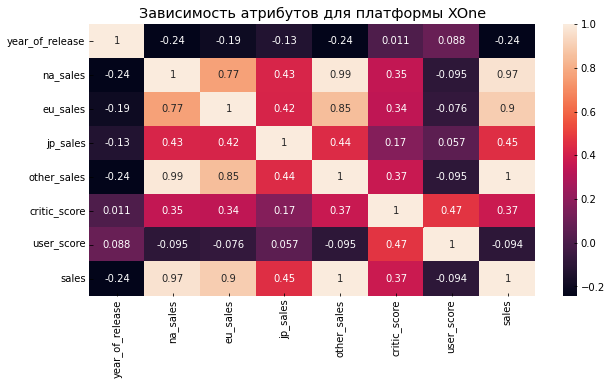

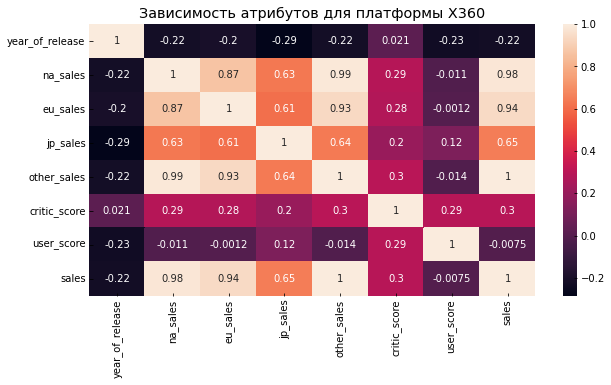

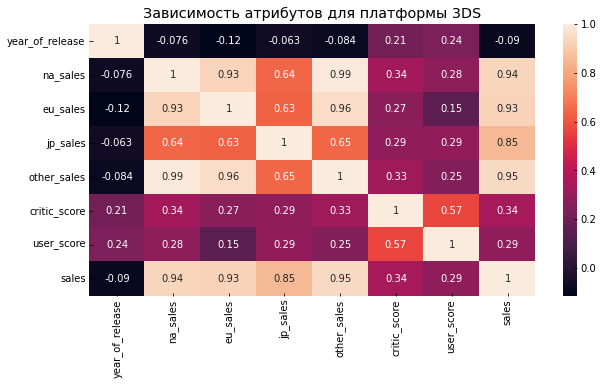

In [73]:
plt_list = ['PS4', 'PS3', 'XOne', 'X360', '3DS']
for i in plt_list:
    plt.figure(figsize=(10,5))
    plt.title(f'Зависимость атрибутов для платформы {i}')
    sns.heatmap(data.query('year_of_release >=2013 & platform == @i').corr(), annot=True)
    plt.show()

Для разных платформ наблюдается немного различная картина, но в целом особенных взаимосвязей не наблюдается.

Так для PS4 взаимосвязь между оценкой пользователей и оценкой критиков достигает значения 0,52 - почти средняя положительная корреляция. Для остальных платформ выявлена не такая сильная взаимосвязь между атрибутами.

Коэффициент корреляции между оценкой критиков и продажами в разных регионах находится в пределах 0,25-0,33 для глобальных платформ PS и Xbox, отдельно выделяется среди 5 топ-платформ 3DS (Nintendo 3DS) - популярная платформа последних лет преимущественно на японском рынке - самые слабые взаимосвязи между значениями продаж и оценок.

Наблюдается практическип прямая связь между продажами в Америке, Европе и другими странами. Продажи в Японии слабо связаны с остальными продажами

### Жанры

Рассмотрим динамику продаж по жанрам с 2009 года

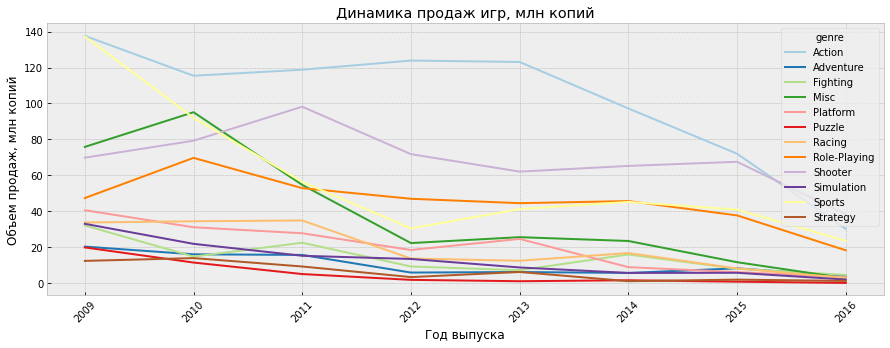

In [74]:
plt.figure(figsize=(15,5))
plt.title('Динамика продаж игр, млн копий')
sns.lineplot(data=data.query('year_of_release >= 2009').groupby(['year_of_release','genre']).sum().reset_index(), 
             x='year_of_release', y='sales', hue='genre', palette='Paired')
plt.xticks(rotation=45)
plt.xlabel('Год выпуска')
plt.ylabel('Объем продаж, млн копий')
plt.show()

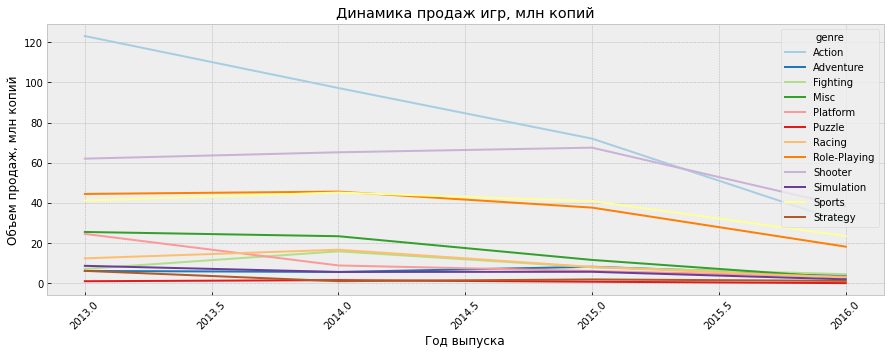

In [75]:
plt.figure(figsize=(15,5))
plt.title('Динамика продаж игр, млн копий')
sns.lineplot(data=data.query('year_of_release >= 2013').groupby(['year_of_release','genre']).sum().reset_index(), 
             x='year_of_release', y='sales', hue='genre', palette='Paired')
plt.xticks(rotation=45)
plt.xlabel('Год выпуска')
plt.ylabel('Объем продаж, млн копий')
plt.show()

In [76]:
data.query('year_of_release >= 2013').groupby(['genre', 'platform']).agg({
            'na_sales' : 'sum', 'eu_sales': 'sum', 'jp_sales':'sum', 'other_sales':'sum',
               'critic_score':'mean', 'user_score':'mean'}).reset_index()

,genre,platform,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score
0,Action,3DS,8.60,6.97,17.09,1.38,64.770833,6.485317
1,Action,DS,0.22,0.24,0.00,0.04,77.666667,4.800000
2,Action,PC,2.34,4.98,0.00,0.57,75.244186,6.617424
3,Action,PS3,23.65,26.81,9.60,10.86,72.330688,6.852273
4,Action,PS4,32.83,42.71,5.90,14.66,73.431818,7.042892
...,...,...,...,...,...,...,...,...
107,Strategy,PSV,0.03,0.03,0.27,0.02,66.000000,5.050000
108,Strategy,Wii,0.15,0.09,0.00,0.02,52.000000,2.800000
109,Strategy,WiiU,0.49,0.36,0.29,0.08,69.500000,7.750000
110,Strategy,X360,0.16,0.10,0.00,0.02,59.000000,5.600000


In [77]:
data.query('year_of_release >= 2013').groupby('genre')['sales'].sum().reset_index().sort_values(by='sales', ascending=False)

,genre,sales
0,Action,322.50
8,Shooter,232.98
10,Sports,150.65
7,Role-Playing,145.89
3,Misc,63.06
4,Platform,42.63
6,Racing,39.89
2,Fighting,35.31
1,Adventure,23.64
9,Simulation,21.76


In [78]:
data.groupby(['genre', 'platform'])['sales'].sum().reset_index().sort_values(by='sales', ascending=False).head(20)

,genre,platform,sales
13,Action,PS3,299.87
265,Sports,Wii,287.91
219,Shooter,X360,276.74
258,Sports,PS2,272.70
12,Action,PS2,272.55
21,Action,X360,238.62
93,Misc,Wii,213.65
210,Shooter,PS3,192.54
158,Racing,PS2,156.12
267,Sports,X360,138.15


Самыми популярными жанрами после 2013 года являются Action, Shooter, Sports, Role-Playing и Misc (на анализируемых топ-5 платформах)

А в целом за всю историю наблюдений следующие жанры на этих плафтормах: Action	на PS3, Sports и Misc на Wii,	Shooter	и Action на X360, Sports и Action на PS.

После 2013 года самые низкие продажи у игр в жанре Strategy и Puzzle, а в целом за всю "историю" игр у жанров Strategy, Puzzle и Adventure

In [79]:
data.groupby(['genre'])['sales'].sum().reset_index().sort_values(by='sales', ascending=False)

,genre,sales
0,Action,1735.63
10,Sports,1326.71
8,Shooter,1050.02
7,Role-Playing,931.77
4,Platform,826.03
3,Misc,794.41
6,Racing,725.82
2,Fighting,443.59
9,Simulation,388.46
5,Puzzle,240.54


Рассмотрим средние и медианные продажи игр по жанрам

In [80]:
data_genre_mean = data.query('year_of_release >= 2013').groupby(['genre']).agg({'name':'count', 'sales' : 'mean'}).reset_index().sort_values(by='sales', ascending=False)
data_genre_mean

,genre,name,sales
8,Shooter,187,1.245882
10,Sports,214,0.703972
4,Platform,74,0.576081
7,Role-Playing,292,0.499623
6,Racing,85,0.469294
2,Fighting,80,0.441375
0,Action,769,0.419376
3,Misc,156,0.404231
9,Simulation,62,0.350968
5,Puzzle,17,0.186471


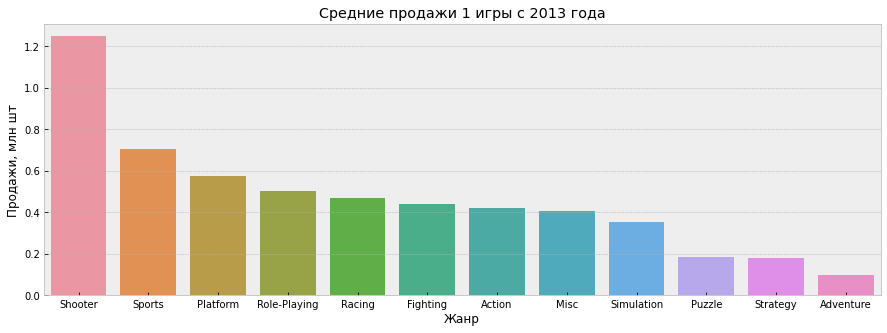

In [81]:
plt.figure(figsize=(15,5))
sns.barplot(data=data_genre_mean, x='genre', y='sales')
plt.title('Средние продажи 1 игры с 2013 года')
plt.xlabel('Жанр')
plt.ylabel('Продажи, млн шт')
plt.show()

In [82]:
data_genre_median = data.query('year_of_release >= 2013').groupby(['genre']).agg({'name':'count', 'sales' : 'median'}).reset_index().sort_values(by='sales', ascending=False)
data_genre_median

,genre,name,sales
8,Shooter,187,0.450
10,Sports,214,0.240
4,Platform,74,0.225
7,Role-Playing,292,0.125
2,Fighting,80,0.125
6,Racing,85,0.120
0,Action,769,0.110
3,Misc,156,0.105
9,Simulation,62,0.100
11,Strategy,56,0.080


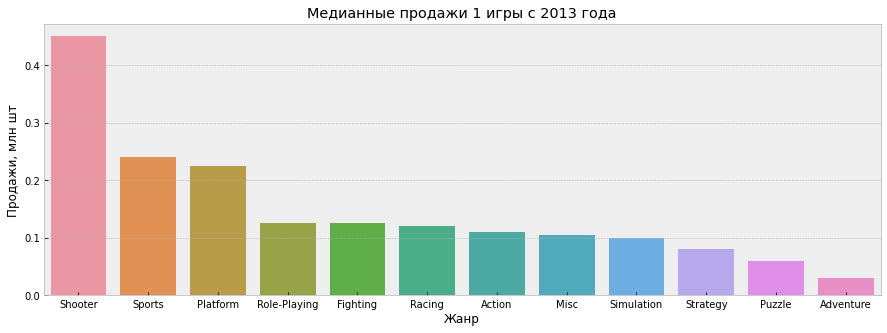

In [83]:
plt.figure(figsize=(15,5))
sns.barplot(data=data_genre_median, x='genre', y='sales')
plt.title('Медианные продажи 1 игры с 2013 года')
plt.xlabel('Жанр')
plt.ylabel('Продажи, млн шт')
plt.show()

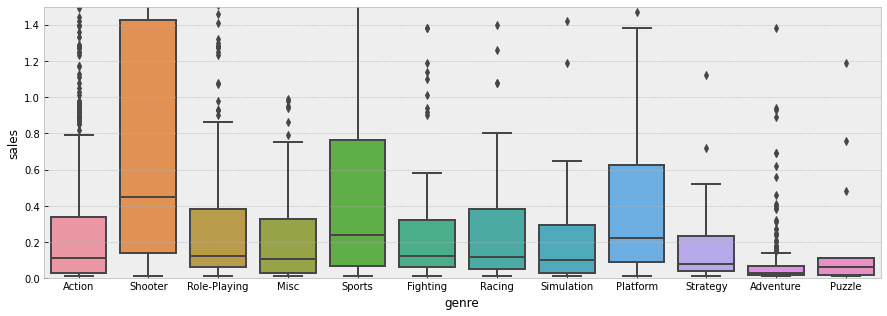

In [84]:
plt.figure(figsize=(15,5))
sns.boxplot(data=data.query('year_of_release >= 2013').sort_values(by='sales', ascending=False), x='genre', y='sales')
plt.ylim(0,1.5)
plt.show()

Как видно из полученных распеределений. Топ-5 жанров по средним и медианным продажам - Shooter, Sports, Platform, Role-Playinh, Fighting и Racing.

Но как мы помyим, самsм продающимся жанром является Action (по общим объемам продаж за всю историю и после 2013 года на анализируемых платформах).

По boxplot в целом видно правильное распеределение популярности жанров. Жанры Action и Misc входят в топ-5 по общим продажам, но таких игр очень много (про оценки ниже и они у этих жанров относительно не плохие), основные продажи набираются за счет "бестселлеров", в то время как основная масса проадется ниже среднего.

Т.о. спиcоr популярных жанров можно все же расширить до 7 - Shooter, Sports, Platform, Role-Playinh, Fighting, Racing, Action

### Распрeделение оценок (дополнительные результаты)

По диаграмме рассеивания пользовательских оценок и оценок критиков ничего определенного сказать не возможно. Для игр после 2013 года большинство оценок находятся в диапазонах [60;100] и [6;10].

На диаграмме средние значения оценок соответствуют указанному диапазону (визуально попадают в скопление точек). Красные пунктирные линии - средние оценки по всему массиву - для всех игр. Синие пунктирные линии - средние оценки для игр после 2103 года выпуска. Желтые пунктирные линии - средние оценки для игр до 2013 года выпуска

Как видно для более новых игр характерны более низкие пользовательские оценки и немного более высокие оценки критиков. чем для игр, выпущенных до 2013 года. Возможно пользователи стали более восприимчивы к игровому процессу и придирчивы к ачеству игр, тетрис уже не вызывает вау-эффекта. 


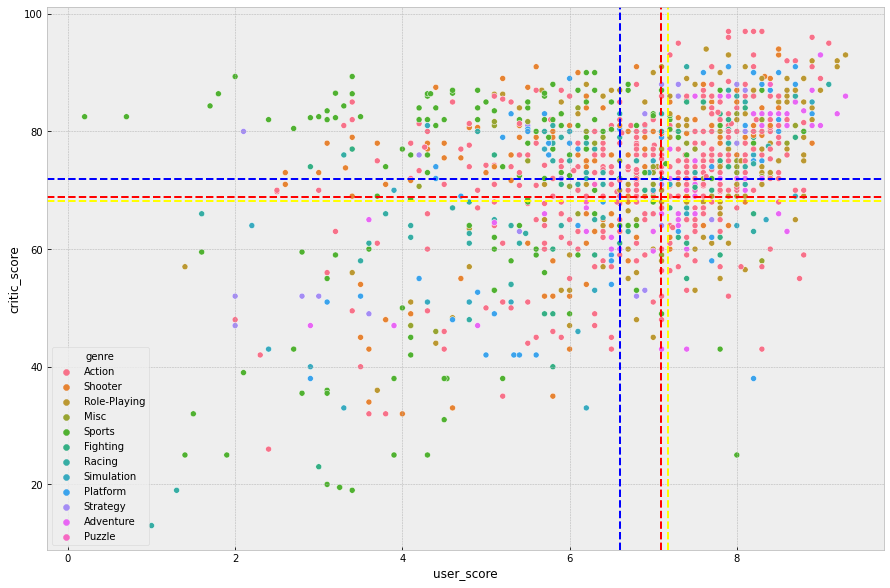

In [85]:
plt.figure(figsize=(15, 10)) 
sns.scatterplot(data=data.query('year_of_release >=2013'), x='user_score', y='critic_score', hue='genre')
plt.axhline(y=data['critic_score'].mean(), color='red', linestyle='--')
plt.axvline(x=data['user_score'].mean(), color='red', linestyle='--')
plt.axhline(y=data.query('year_of_release >=2013')['critic_score'].mean(), color='blue', linestyle='--')
plt.axvline(x=data.query('year_of_release >=2013')['user_score'].mean(), color='blue', linestyle='--')
plt.axhline(y=data.query('year_of_release < 2013')['critic_score'].mean(), color='yellow', linestyle='--')
plt.axvline(x=data.query('year_of_release < 2013')['user_score'].mean(), color='yellow', linestyle='--')
plt.show()

In [86]:
print('Средняя оценка пользователей всех игр', round(data['user_score'].mean(), 2))
print('Средняя оценка критиков всех игр', round(data['critic_score'].mean(), 2))
print()
print('Средняя оценка пользователей всех игр, выпущенных до 2013 года', round(data.query('year_of_release < 2013')['user_score'].mean(), 2))
print('Средняя оценка критиков всех игр, , выпущенных до 2013 года', round(data.query('year_of_release < 2013')['critic_score'].mean(), 2))
print()
print('Средняя оценка пользователей всех игр, выпущенных после 2013 года', round(data.query('year_of_release >= 2013')['user_score'].mean(), 2))
print('Средняя оценка критиков всех игр, , выпущенных после 2013 года', round(data.query('year_of_release >= 2013')['critic_score'].mean(), 2))


Средняя оценка пользователей всех игр 7.09
Средняя оценка критиков всех игр 68.78

Средняя оценка пользователей всех игр, выпущенных до 2013 года 7.18
Средняя оценка критиков всех игр, , выпущенных до 2013 года 68.24

Средняя оценка пользователей всех игр, выпущенных после 2013 года 6.6
Средняя оценка критиков всех игр, , выпущенных после 2013 года 71.94


Земетен также различный диапазон в оценивании игр в зависимости от жанра или платформы игры.

Например, игры в жанрах Action, Adventure, Puzzle оненивают чаще в более узких диапазонахх оценок, т.е. пользователи чаще сходятся во мнении, что игры данных жанров имеют схожие оценки, в отличие от игр в жанрах стратегий, платформеров и симуляторов.

В тоже время критики более консервативны в оценивании и особого большого разброса в оценках нет.

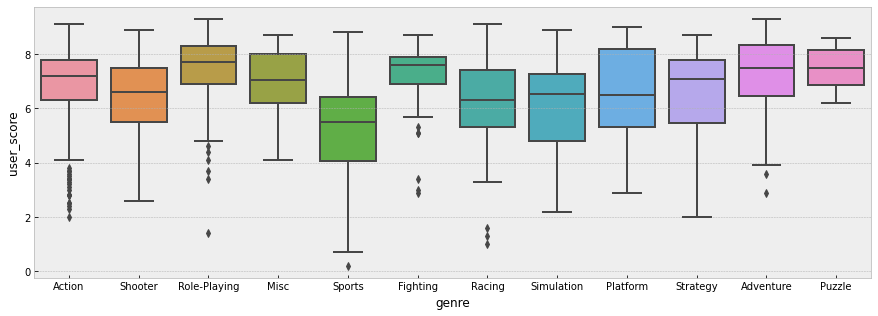

In [87]:
plt.figure(figsize=(15,5))
sns.boxplot(data=data.query('year_of_release >=2013'), x='genre', y='user_score')
plt.show()

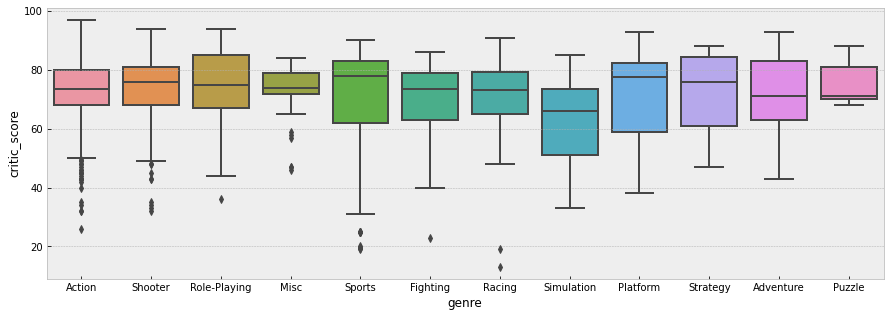

In [88]:
plt.figure(figsize=(15,5))
sns.boxplot(data=data.query('year_of_release >=2013'), x='genre', y='critic_score')
plt.show()

В части плафторм также заметна особенность оценивания пользователями и критиками игр для портативных консолей. Явно видно, что оценки игр на PSP, PSV и DS ледат в более узком диапазоне, чем оценки игр для других платформ.

Скорее всего связано это с тем, что на портативные консоли выпускаются игры, которые должны быть полностью оптимизированны под такие устройства, и разработчикам нельзя облажаться при выпуске игры на портативные устройства. Также чаще подобные игры выпускаются для потративных устройств с задержкой после выхода аналогичных игр для "больших" консолей, т.е. с учетом возможных ошибок и доделок, что качественно в лучшую сторону влияет на игру и пользовательский опыт

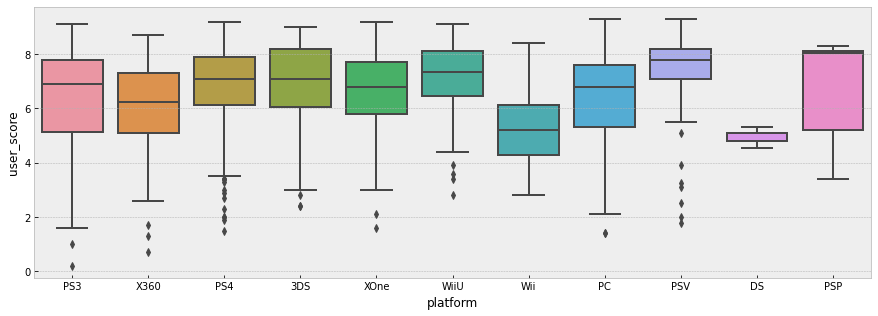

In [89]:
plt.figure(figsize=(15,5))
sns.boxplot(data=data.query('year_of_release >=2013'), x='platform', y='user_score')
plt.show()

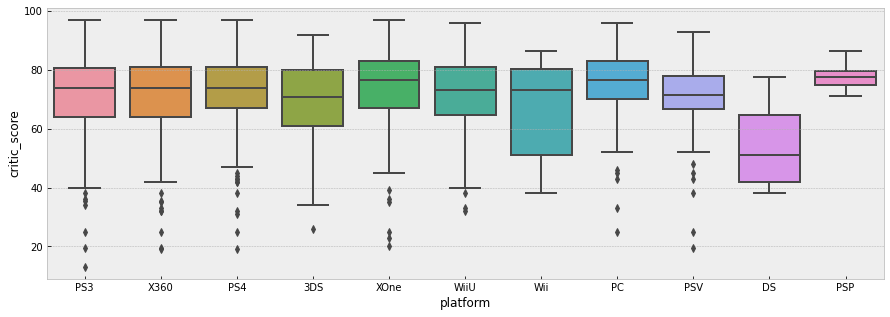

In [90]:
plt.figure(figsize=(15,5))
sns.boxplot(data=data.query('year_of_release >=2013'), x='platform', y='critic_score')
plt.show()

## Портрет пользователя

*Частично на некоторые вопросы уже были даны ответы*

### Популярность платформ в разрезе региона

In [91]:
#сгруппируем даныне по платформе
data_platform = data.query('year_of_release >= 2013').pivot_table(index='platform',
                                                  values=['na_sales', 'eu_sales', 'jp_sales', 'other_sales','sales'],
                                                  aggfunc='sum').reset_index()
data_platform['na_ratio'] = data_platform['na_sales']/data_platform['sales']
data_platform['eu_ratio'] = data_platform['eu_sales']/data_platform['sales']
data_platform['jp_ratio'] = data_platform['jp_sales']/data_platform['sales']
data_platform['other_ratio'] = data_platform['other_sales']/data_platform['sales']

data_platform = data_platform[['platform',
                               'na_sales', 'eu_sales', 'jp_sales', 'other_sales', 
                               'na_ratio', 'eu_ratio', 'jp_ratio', 'other_ratio',
                               'sales']]

In [92]:
#распределение в целом
data_platform

,platform,na_sales,eu_sales,jp_sales,other_sales,na_ratio,eu_ratio,jp_ratio,other_ratio,sales
0,3DS,38.20,30.96,67.81,6.28,0.266667,0.216126,0.473368,0.043839,143.25
1,DS,0.57,0.85,0.00,0.12,0.370130,0.551948,0.000000,0.077922,1.54
2,PC,11.19,25.84,0.00,3.03,0.279331,0.645032,0.000000,0.075637,40.06
3,PS3,63.50,67.81,23.35,26.77,0.349997,0.373753,0.128700,0.147550,181.43
4,PS4,108.74,141.09,15.96,48.35,0.346151,0.449131,0.050805,0.153912,314.14
5,PSP,0.00,0.17,3.53,0.04,0.000000,0.045455,0.943850,0.010695,3.74
6,PSV,5.04,6.10,18.59,3.26,0.152774,0.184905,0.563504,0.098818,32.99
7,Wii,6.56,5.93,0.05,1.12,0.480234,0.434114,0.003660,0.081991,13.66
8,WiiU,29.21,19.85,10.88,4.69,0.451957,0.307133,0.168343,0.072567,64.63
9,X360,81.66,42.52,0.51,12.11,0.596930,0.310819,0.003728,0.088523,136.80


In [93]:
#топ-5 платформ для рынков
for i in ['na_ratio', 'eu_ratio','jp_ratio', 'other_ratio']:
    display(i)
    display(data_platform[['platform', i]].sort_values(by=i, ascending=False).head(5).style.background_gradient(cmap='Blues', axis=0))

'na_ratio'

,platform,na_ratio
9,X360,0.596930
10,XOne,0.584484
7,Wii,0.480234
8,WiiU,0.451957
1,DS,0.370130


'eu_ratio'

,platform,eu_ratio
2,PC,0.645032
1,DS,0.551948
4,PS4,0.449131
7,Wii,0.434114
3,PS3,0.373753


'jp_ratio'

,platform,jp_ratio
5,PSP,0.943850
6,PSV,0.563504
0,3DS,0.473368
8,WiiU,0.168343
3,PS3,0.128700


'other_ratio'

,platform,other_ratio
4,PS4,0.153912
3,PS3,0.147550
6,PSV,0.098818
10,XOne,0.089568
9,X360,0.088523


Таким образом:
- для рынка Америки самые популярные платформы Xbox и Wii текущего и прошлого поколений (58-59% и 44-45% рынка всех игр на этих консолях соответственно
- для рынка Европы самые популярные платформы - DS и ПК - 65% и 55% рынка соответственно. Также почти половину всех продаж приходится на платформы Play Station текущего и прошлого поколений
- для рынка Японии самоми популярными плафтормами являются портативные платформы, особенно PSP (94% всего рынка игр для этой консоли), а также PS Vita. В 2 раза больше игр в Японии продано для платформы 3DS, чем в Америке и Европе
- для остального рынка самыми популярными платформами являются PS4 и PS3

Полная информация о популярных платформах в таблицах выше

### Популярность жанров в разрезе региона

In [94]:
#сгруппируем даныне по жанру
data_genre = data.query('year_of_release >= 2013').pivot_table(index='genre',
                                                  values=['na_sales', 'eu_sales', 'jp_sales', 'other_sales','sales'],
                                                  aggfunc='sum').reset_index()
data_genre['na_ratio'] = data_genre['na_sales']/data_genre['sales']
data_genre['eu_ratio'] = data_genre['eu_sales']/data_genre['sales']
data_genre['jp_ratio'] = data_genre['jp_sales']/data_genre['sales']
data_genre['other_ratio'] = data_genre['other_sales']/data_genre['sales']

data_genre = data_genre[['genre',
                               'na_sales', 'eu_sales', 'jp_sales', 'other_sales', 
                               'na_ratio', 'eu_ratio', 'jp_ratio', 'other_ratio',
                               'sales']]

In [95]:
#распределение в целом
data_genre

,genre,na_sales,eu_sales,jp_sales,other_sales,na_ratio,eu_ratio,jp_ratio,other_ratio,sales
0,Action,126.13,118.61,40.49,37.27,0.391101,0.367783,0.125550,0.115566,322.50
1,Adventure,7.14,8.25,5.82,2.43,0.302030,0.348985,0.246193,0.102792,23.64
2,Fighting,15.55,8.55,7.65,3.56,0.440385,0.242141,0.216653,0.100821,35.31
3,Misc,27.49,20.04,9.44,6.09,0.435934,0.317793,0.149699,0.096575,63.06
4,Platform,18.14,15.58,4.79,4.12,0.425522,0.365470,0.112362,0.096646,42.63
5,Puzzle,0.83,1.00,1.18,0.16,0.261830,0.315457,0.372240,0.050473,3.17
6,Racing,12.96,20.19,2.30,4.44,0.324893,0.506142,0.057659,0.111306,39.89
7,Role-Playing,46.40,36.97,51.04,11.48,0.318048,0.253410,0.349853,0.078689,145.89
8,Shooter,109.74,87.86,6.61,28.77,0.471028,0.377114,0.028372,0.123487,232.98
9,Simulation,4.86,10.92,4.52,1.46,0.223346,0.501838,0.207721,0.067096,21.76


In [96]:
#топ-5 жанров для рынков
for i in ['na_ratio', 'eu_ratio','jp_ratio', 'other_ratio']:
    display(i)
    display(data_genre[['genre', i]].sort_values(by=i, ascending=False).head(5).style.background_gradient(cmap='Blues', axis=0))

'na_ratio'

,genre,na_ratio
8,Shooter,0.471028
2,Fighting,0.440385
3,Misc,0.435934
10,Sports,0.433256
4,Platform,0.425522


'eu_ratio'

,genre,eu_ratio
6,Racing,0.506142
9,Simulation,0.501838
11,Strategy,0.418651
10,Sports,0.401726
8,Shooter,0.377114


'jp_ratio'

,genre,jp_ratio
5,Puzzle,0.372240
7,Role-Playing,0.349853
1,Adventure,0.246193
2,Fighting,0.216653
9,Simulation,0.207721


'other_ratio'

,genre,other_ratio
10,Sports,0.129107
8,Shooter,0.123487
0,Action,0.115566
6,Racing,0.111306
1,Adventure,0.102792


Самые поплярные жанры:
- для рынка Америки - шутеры и файтинги (ага!! колумбайн, ай ай ай) - 47 и 44% от общих продаж данных жанров в мире
- для рынка Европы - гонки и симуляторы, практически по 50% продаж 
- для рынка Японии - логические игры, рПГ и приключения
- для остальных рынков - спортивные игры, шутеры и аркады

Полная информация о популряных жанрах в таблицах выше

### Рейтинг ESRB

Как видно из представленной ниже таблицы в Америке и Европе лучше продаются игры кактгории М, т.е. для 17 и старше, наименее поулярнее игры для игроков 13+.

В Японии же наоборот "игры для взрослых" не так популярны (см. 2-ю таблицу). В основном игроки - 13+ на портативных консолях - ученики старших классов.

В остальном мире также второй по популярности категорией игры являются игры без ограничения возраста.

In [97]:
data_esrb = data.query('year_of_release >= 2013').pivot_table(index='rating',
                                                  values=['na_sales', 'eu_sales', 'jp_sales', 'other_sales','sales'],
                                                  aggfunc='sum').reset_index()
data_esrb.sort_values(by='sales', ascending=False)

,rating,eu_sales,jp_sales,na_sales,other_sales,sales
2,M,145.80,14.11,165.29,47.11,372.31
0,E,83.36,15.14,79.05,22.61,200.16
3,T,41.95,20.59,49.79,14.29,126.62
1,E10+,42.69,5.89,54.24,12.57,115.39


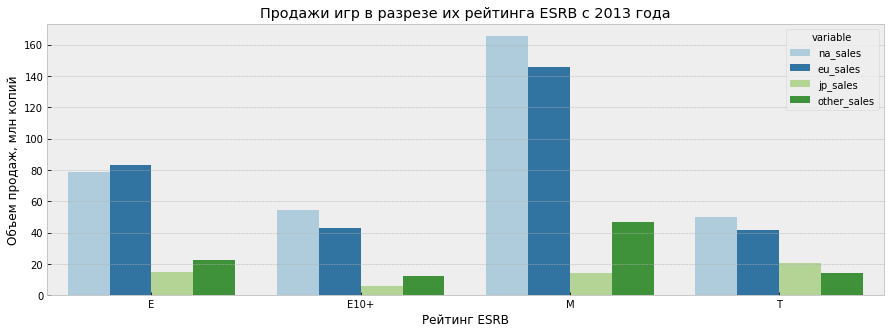

In [98]:
#чтобы визуализировать необходимо выполнить свертывание таблицы
data_esrb_unpivot = pd.melt(data_esrb, id_vars='rating', value_vars=['na_sales', 'eu_sales', 'jp_sales', 'other_sales'])
plt.figure(figsize=(15,5))
plt.title('Продажи игр в разрезе их рейтинга ESRB с 2013 года')
sns.barplot(data=data_esrb_unpivot, x='rating', y='value', hue='variable', palette='Paired')
plt.xlabel('Рейтинг ESRB')
plt.ylabel('Объем продаж, млн копий')
plt.show()

In [99]:
data_esrb_2 = data.query('year_of_release >= 2009').pivot_table(index='rating',
                                                  values=['na_sales', 'eu_sales', 'jp_sales', 'other_sales','sales'],
                                                  aggfunc='sum').reset_index()
data_esrb_2.sort_values(by='sales', ascending=False)

,rating,eu_sales,jp_sales,na_sales,other_sales,sales
3,M,328.96,35.66,443.10,110.96,918.68
0,E,261.78,61.49,404.47,84.60,812.34
5,T,153.56,50.62,227.58,55.66,487.42
1,E10+,123.51,20.82,205.17,41.40,390.90
2,EC,0.00,0.00,1.32,0.08,1.40
4,RP,0.03,0.00,0.00,0.01,0.04


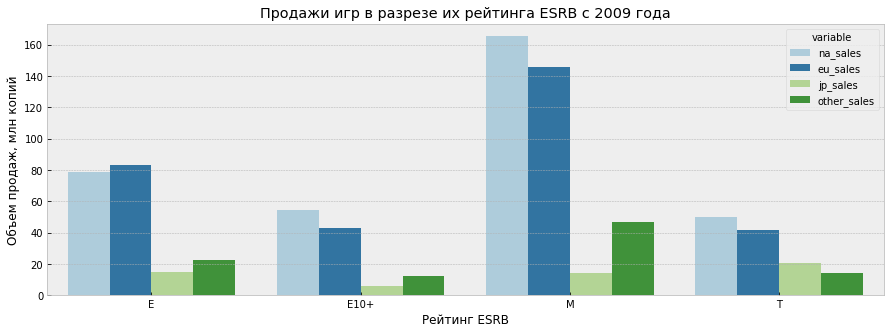

In [100]:
data_esrb_unpivot_2 = pd.melt(data_esrb_2, id_vars='rating', value_vars=['na_sales', 'eu_sales', 'jp_sales', 'other_sales'])
plt.figure(figsize=(15,5))
plt.title('Продажи игр в разрезе их рейтинга ESRB с 2009 года')
sns.barplot(data=data_esrb_unpivot, x='rating', y='value', hue='variable', palette='Paired')
plt.xlabel('Рейтинг ESRB')
plt.ylabel('Объем продаж, млн копий')
plt.show()

Однако отметим, что в данное распеределние не попали игры, для которых неопределен рейтинг. Но предположим, что для остальных игр такие зависимости продаж аналогичные.

## Проверка гипотез

### Подготовительный этап

1) Проведем проверку данных на нормальность, воспользуемся критерием Шапиро-Уилка, зададим значение α = 0,05

In [101]:
α = 0.05

In [102]:
#с помощью цикла преобразуем столбцы в списки и применим критерий Шапиро-Уилка
for i in ['na_sales', 'eu_sales', 'jp_sales', 'other_sales', 'user_score', 'critic_score']:
    lst = data[i].tolist()
    result = st.shapiro(lst)
    p_value = result[1]
    print(f'р-значение для {i}:', p_value)

р-значение для na_sales: 0.0
р-значение для eu_sales: 0.0
р-значение для jp_sales: 0.0
р-значение для other_sales: 0.0
р-значение для user_score: 1.0
р-значение для critic_score: 1.0


/opt/conda/lib/python3.9/site-packages/scipy/stats/_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Все р-значения равны 0, что свидетельствует о том, что данные распеределены ненормально. Это говорит от том, что скорее всего данные реальные.

Поэтому для проверки гипотез будем применять непараметрический критерий Манна-Уитни. Также данный критерий позволит сравнить массивы разного размера, в отличие, например, от критерия Уилкоксона

**2) Статистически значимая разница**

Проверим все возможные комбинации данных (столбцов оригинального набора) на статистически значимую разницу. С помощью цикла сформируем комбинации и применим к ним критерий Манна-Уитни.

Сформулируем гипотезы:
- H0: Между данными отсутствует статистическая разница
- H1: Между данными разница статистически значима

In [103]:
d1 = []
d2 =[]
des =[]
pv = []

for i in ['na_sales', 'eu_sales', 'jp_sales', 'other_sales', 'user_score', 'critic_score']:
    for j in ['eu_sales', 'jp_sales', 'other_sales', 'user_score', 'critic_score']:
        results = st.mannwhitneyu(data[i].tolist(), data[j].tolist(), use_continuity=True, alternative='less')
        if results.pvalue < α:
            d1.append(f'{i}')
            d2.append(f'{j}')
            des.append('разница статистически значима')
            pv.append(results.pvalue)
        else:
            d1.append(f'{i}')
            d2.append(f'{j}')
            des.append('нет статистически значимой разницы')
            pv.append(results.pvalue)
            
            
#            print(f'Разница для пары {i}-{j} статистически значима', round(results.pvalue, 4))
#        else:
#            print(f'Нет статистически значимой разницы для пары {i}-{j}', round(results.pvalue, 4))

In [104]:
pv_data = {'d1': d1, 'd2': d2, 'description' : des, 'p-value' : pv}
df = pd.DataFrame(pv_data)
df.sort_values(by='p-value', ascending=True)

,d1,d2,description,p-value
10,jp_sales,eu_sales,разница статистически значима,0.000000e+00
15,other_sales,eu_sales,разница статистически значима,6.637567e-197
12,jp_sales,other_sales,разница статистически значима,1.621378e-139
5,eu_sales,eu_sales,нет статистически значимой разницы,5.000002e-01
17,other_sales,other_sales,нет статистически значимой разницы,5.000002e-01
11,jp_sales,jp_sales,нет статистически значимой разницы,5.000003e-01
0,na_sales,eu_sales,нет статистически значимой разницы,1.000000e+00
1,na_sales,jp_sales,нет статистически значимой разницы,1.000000e+00
2,na_sales,other_sales,нет статистически значимой разницы,1.000000e+00
6,eu_sales,jp_sales,нет статистически значимой разницы,1.000000e+00


Как видно, получилась какая-то полная ерунда. Между jp_sales и critic_score разница статистически значима и одноврменно между
critic_score и jp_sales	нет статистически значимой разницы.

Скорее всего данные неоднородны и сравниваем "холодное" с "красным".

С другой стороны стало известно, что например:
между jp_sales и	eu_sales,	other_sales	и eu_sales,	jp_sales и	other_sales	разница статистически значима

### Пользовательские рейтинги на платформах

Сформулируем слуедующую гипотезу: **Средние пользовательские рейтинги платформ Xbox One и PC одинаковые**. Т.е.
- Н0: между пользовательскими рейтингами на платформах XOne и РС нет статистически значимой разницы
- Н1: различия между пользовательскими рейтингам ина платформах XOne и РС статистически значимы

Напишем функцию расчета значения критерия Манна-Уитни
    

In [105]:
def diff(data_A, data_B):
    p_value = stats.mannwhitneyu(data_A, data_B, use_continuity=True, alternative='less')[1]
    print('P-value: {0:.3f}'.format(p_value))
    print('Среднее первого набора данных: {0:.3f}'.format(data_A.mean()))
    print('Среднее второго набора данных: {0:.3f}'.format(data_B.mean()))
    if (p_value < α):
        print('Отвергаем H0: разница статистически значима')
    else:
        print('Не отвергаем H0: вывод о различии сделать нельзя')


Применим функцию для значений пользовательских оценок для различных платоформ. Сначала для игр, выпущенных после 2013 года, а потом для всего массива

In [106]:
diff(data.query('year_of_release >= 2013 & platform == "XOne"')['user_score'], data.query('year_of_release >= 2013 & platform == "PC"')['user_score'])

P-value: nan
Среднее первого набора данных: 6.604
Среднее второго набора данных: 6.264
Не отвергаем H0: вывод о различии сделать нельзя


In [107]:
diff(data.query('platform == "XOne"')['user_score'], data.query('platform == "PC"')['user_score'])

P-value: nan
Среднее первого набора данных: 6.604
Среднее второго набора данных: 7.062
Не отвергаем H0: вывод о различии сделать нельзя


Таким образом, **особой разницы между пользовательскими оценка на 2-х разных платформах нет**, но только при условии, что оценки выставлены играм, которые выходили в одно время а этих 2-х плафтормах. 

Если сравнивать данные о всех играх, то появится статистически значимая разница в оценках, т.к. для большинства игр, вышедших до 2013 года нет оценок для платформы Xbox One (дата выхода платформы 22 ноября 2013 года), а для PC есть оценки за всю историю наблюдений

### Пользовательские рейтинги жанров

Сформулируем следующию гипотезу: Средние пользовательские рейтинги жанров Action и  Sports разные, т.е.:
- Н0: между оценками пользователей игр в жанрах Action и Sports нет статистической значимой разницы
- H1: различия между пользовательскими рейтингам игр в жанрах Action и Sports статистически значимы

Аналогично предыдущему пункту применим функцию расчета р-значения и сравним результат на 2-х массивах. 

In [108]:
diff(data.query('year_of_release >= 2013 & genre == "Action"')['user_score'], data.query('year_of_release >= 2013 & genre == "Sports"')['user_score'])

P-value: nan
Среднее первого набора данных: 6.860
Среднее второго набора данных: 5.192
Не отвергаем H0: вывод о различии сделать нельзя


In [109]:
diff(data.query('genre == "Action"')['user_score'], data.query('genre == "Sports"')['user_score'])

P-value: nan
Среднее первого набора данных: 7.026
Среднее второго набора данных: 6.924
Не отвергаем H0: вывод о различии сделать нельзя


Т.о. особой разницы между пользовательскими оценками жанров нет

### Доп.тесты

#### Тест Колмогорова-Смирнова

1) Пользовательские оценки на плафтормах

In [110]:
def diff_ks(data_A, data_B):
    p_value = stats.ks_2samp(data_A, data_B)[1]
    print('P-value: {0:.3f}'.format(p_value))
    print('Среднее первого набора данных: {0:.3f}'.format(data_A.mean()))
    print('Среднее второго набора данных: {0:.3f}'.format(data_B.mean()))
    if (p_value < α):
        print('Отвергаем H0: разница статистически значима')
    else:
        print('Не отвергаем H0: вывод о различии сделать нельзя')

In [111]:
diff_ks(data.query('year_of_release >= 2013 & platform == "XOne"')['user_score'], data.query('year_of_release >= 2013 & platform == "PC"')['user_score'])

P-value: 0.094
Среднее первого набора данных: 6.604
Среднее второго набора данных: 6.264
Не отвергаем H0: вывод о различии сделать нельзя


2) Пользовательские оценки жанров

In [112]:
diff_ks(data.query('year_of_release >= 2013 & genre == "Action"')['user_score'], data.query('year_of_release >= 2013 & genre == "Sports"')['user_score'])

P-value: 0.000
Среднее первого набора данных: 6.860
Среднее второго набора данных: 5.192
Отвергаем H0: разница статистически значима


## Общий вывод

В рамках работы были изучены данные о продажах игр различных жанров для различных платформ. В ходе работы была проведена предобработка данных, исследовательский анализ данных, а также проверены некоторые гипотезы.

Для нужд заказчика предлагается строить дальнейший прогноз продаж игр на основании данных о выпуске игр после 2013 года.

**1) В рамках исследовательского анализа данных выявлено следующее:**
- бум геймдева пришелся на 2002 год. С конца 90-х началось массовое распространение интернета, появлись новые технологие, была выпущена консоль PS2. В целом начало 2000 характеризуется большими инновациями в разработке игр, появлением новых модификаций от пользователей, что привелок росту популярности компьютерных игр, особенно в жанре ММО. В количественном выражении наблюдается рост "выпуска игр", который длится до 2009 года, после которго начинается спад выпуска игр и спад их физических продаж. Хотя каких-либо реальных подтверждений такой динамики нет, но можно предположить, что подобный спад связан с расцветом пиратства и распространением торрект-трекеров.
- продажи в Северной Америке и Европе (а, следовательно, и популярность игр или "ожидания от релиза") примерно одинаковые, т.к. рынки похожи, в Японии своя игровая вселенная и иные предпочтения из-за культурных различий.
- основными классами во всех жанрах игр являются рейтингом Е (все), Е10+ (все от 10 лет), Т (тинейджеры от 13 до 17), M (старше 17)
- наиболее популярными платформами за всю историю являются PS2-3, Xbox360, Wii, DS

Динамика объема продаж (в реальном выражении) вполне логична и подчиняется примерно следующему закону:
- бурный рост в течении 2-3 лет или резкий скачок продаж,
- хайп (стабильное плато)
- постепенное затухание
Такая картина характерна в основном для консолей. В целом для консолей также характерно то, что основная масса пользователей (не фанаты) покупают консоли через 1-2 года, т.к. за это время после появления новой консоли происходит её доработка и модернизация, "допилка" игр.

Немного другая динамика для PC, для которых динамика продаж соответствует общему тренду динамики продаж. Резкий рост в 2009-2011, далее спад. до 2007 года - колебания в окрестности 5 млн копий в год.

Среднее время жизни консоли составляет 7-10 лет. В теории консоли нового поколения появляются раз в 5 лет

По предоставленным данным видны некоторые закономерности. На примере консолей Play Station прослеживается:
- приемственность поколений консолей (продажи игр на новые консоли, а следовательно продажи и появление самих новых консолей, начинаются на нисходящем тренде консолей предыдущего поколения)
- борьба конкурентов за рынок (одновременный выход на рынок PS3 и X360, PS4 и XOne)

В целом для всего массива (для всех годов) выявляются сильные корреляции между продажами в Америке и Европе, а также между общими продажами и продажами в Америке и Европе. Оценки пользователей и продажи не связаны между собой - с натяжкой, корреляцию между продажами в Америке, Европе, общими продажами и оценкой критиков можно назвать слабой (около 0,3). Возможно, в оценке критиков учитывается объем продаж.

**2) Анализ в ретроспективе 2013-2016 гг.**

**2.1)** С начала 2009 года наблюдается спад продаж всех игр на всех платформах. В период 2013- 2016 гг.  полностью нивелируется влияние старых платформ, продажи игр для одних из самых популярных консолей в мире РS3 и Х360 будут на минимуме. Также (судя по данным за 2016 год) продажи игр для популярных консолей следующего поколения PS4 и XOne также находятся на нисходящем тренде:
- для рассмариваемого периода самыми популярными и "перспективными" платформами являются - PS4, PS3, XOne, 3DS, X360
- для разных платформ наблюдается немного различная картина в корреляции оценок и продаж, но в целом особенных взаимосвязей не наблюдается. Так для PS4 взаимосвязь между оценкой пользователей и оценкой критиков достигает значения 0,52 - почти средняя положительная корреляция. Для остальных платформ выявлена не такая сильная взаимосвязь между атрибутами.
- коэффициент корреляции между оценкой критиков и продажами в разных регионах находится в пределах 0,25-0,33 для глобальных платформ PS и Xbox, отдельно выделяется среди 5 топ-платформ 3DS (Nintendo 3DS) - популярная платформа последних лет преимущественно на японском рынке - самые слабые взаимосвязи между значениями продаж и оценок.
- наблюдается практическип прямая связь между продажами в Америке, Европе и другими странами. Продажи в Японии слабо связаны с остальными продажами

**2.2)** Самыми популярными жанрами после 2013 года являются Action, Shooter, Sports, Role-Playing и Misc. А в целом за всю историю наблюдений следующие жанры на этих плафтормах: Action на PS3, Sports и Misc на Wii, Shooter и Action на X360, Sports и Action на PS. После 2013 года самые низкие продажи у игр в жанре Strategy и Puzzle, а в целом за всю "историю" игр у жанров Strategy, Puzzle и Adventure

С точки зрения средних продаж 1 игры, наиболее популярными жанрами являются Shooter, Sports, Platform, Role-Playinh, Fighting и Racing. Да, Жанры Action и Misc входят в топ-5 по общим продажам, но таких игр очень много (про оценки ниже и они у этих жанров относительно не плохие), основные продажи набираются за счет "бестселлеров", в то время как основная масса проадется ниже среднего.

Для более новых игр характерны более низкие пользовательские оценки и немного более высокие оценки критиков. чем для игр, выпущенных до 2013 года. Возможно пользователи стали более восприимчивы к игровому процессу и придирчивы к ачеству игр, тетрис уже не вызывает вау-эффекта. 

Земетен также различный диапазон в оценивании игр в зависимости от жанра или платформы игры. Например, игры в жанрах Action, Adventure, Puzzle оненивают чаще в более узких диапазонахх оценок, т.е. пользователи чаще сходятся во мнении, что игры данных жанров имеют схожие оценки, в отличие от игр в жанрах стратегий, платформеров и симуляторов. 
В тоже время критики более консервативны в оценивании и особого большого разброса в оценках нет.

В части плафторм также заметна особенность оценивания пользователями и критиками игр для портативных консолей. Явно видно, что оценки игр на PSP, PSV и DS лежат в более узком диапазоне, чем оценки игр для других платформ. 
Скорее всего связано это с тем, что на портативные консоли выпускаются игры, которые должны быть полностью оптимизированны под такие устройства, и разработчикам нельзя облажаться при выпуске игры на портативные устройства. Также чаще подобные игры выпускаются для потративных устройств с задержкой после выхода аналогичных игр для "больших" консолей, т.е. с учетом возможных ошибок и доделок, что качественно в лучшую сторону влияет на игру и пользовательский опыт


**2.3) Популярность:**

**Платформы**

- для рынка Америки самые популярные платформы Xbox и Wii текущего и прошлого поколений (58-59% и 44-45% рынка всех игр на этих консолях соответственно
- для рынка Европы самые популярные платформы - DS и ПК - 65% и 55% рынка соответственно. Также почти половину всех продаж приходится на платформы Play Station текущего и прошлого поколений
- для рынка Японии самоми популярными плафтормами являются портативные платформы, особенно PSP (94% всего рынка игр для этой консоли), а также PS Vita. В 2 раза больше игр в Японии продано для платформы 3DS, чем в Америке и Европе
- для остального рынка самыми популярными платформами являются PS4 и PS3

**Жанры:**

- для рынка Америки - шутеры и файтинги - 47 и 44% от общих продаж данных жанров в мире
- для рынка Европы - гонки и симуляторы, практически по 50% продаж
- для рынка Японии - логические игры, РПГ и приключения
- для остальных рынков - спортивные игры, шутеры и аркады

**Рейтинг ESRB**

- в Америке и Европе лучше продаются игры кактгории М, т.е. для 17 и старше, наименее поулярнее игры для игроков 13+.
- в Японии же наоборот "игры для взрослых" не так популярны (см. 2-ю таблицу). В основном игроки - 13+ на портативных консолях - ученики старших классов.
- в остальном мире также второй по популярности категорией игры являются игры без ограничения возраста.


**3) Была проведена проверка различных гипотез**. Предварительно осуществлена проверка нормальности данных и выбран критерий Манна-Утни для дальнейшего анализа:
- определено, что особой разницы между пользовательскими оценка на 2-х разных платформах нет, но только при условии, что оценки выставлены играм, которые выходили в одно время а этих 2-х плафтормах. Если сравнивать данные о всех играх, то появится статистически значимая разница в оценках, т.к. для большинства игр, вышедших до 2013 года нет оценок для платформы Xbox One (дата выхода платформы 22 ноября 2013 года), а для PC есть оценки за всю историю наблюдений.
- между оценками пользователей игр в жанрах Action и Sports есть статистически значимая разница


Таким образом заказчику целесообразно в будущем году для запуска новой кампании по продажам игр сконцентрироваться на играх в жанрах Sports, Racing, Shouter, Simulator на платформах PS3, PS4, PC и DS, как самых популярных жанрах и платформах в Европе и остальном мире(куда теоретически входит Россия).